## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

Processing:  ../camera_cal/calibration1.jpg


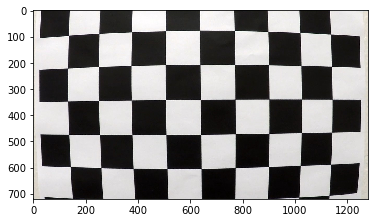

Undistorted


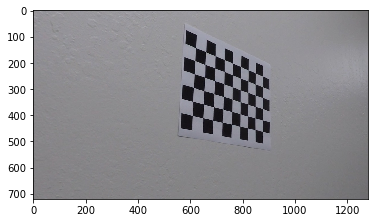

Processing:  ../camera_cal/calibration10.jpg


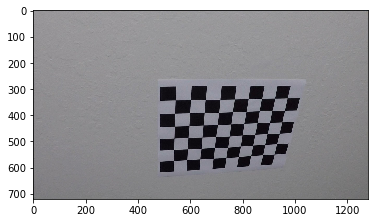

Undistorted


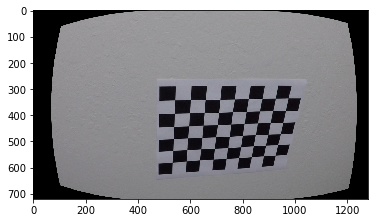

Processing:  ../camera_cal/calibration11.jpg


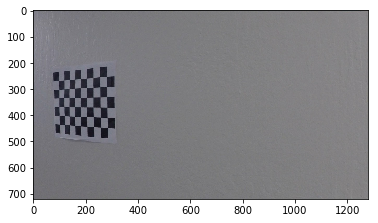

Undistorted


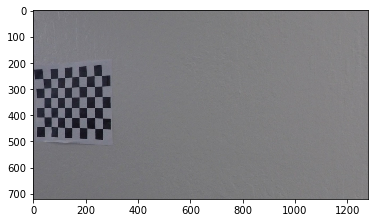

Processing:  ../camera_cal/calibration12.jpg


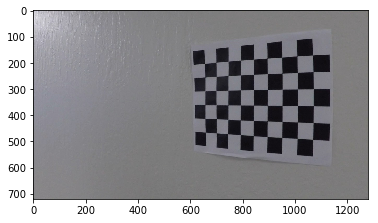

Undistorted


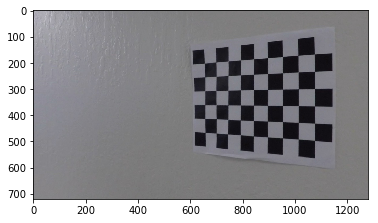

Processing:  ../camera_cal/calibration13.jpg


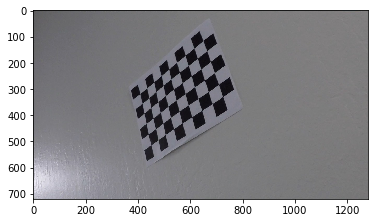

Undistorted


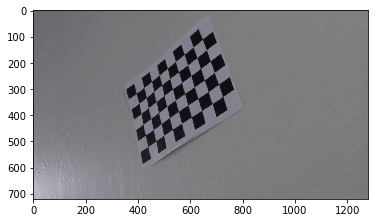

Processing:  ../camera_cal/calibration14.jpg


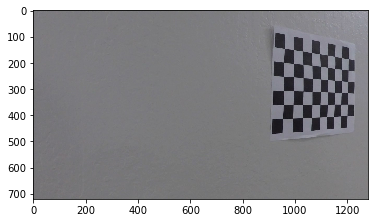

Undistorted


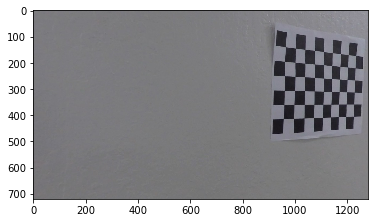

Processing:  ../camera_cal/calibration15.jpg


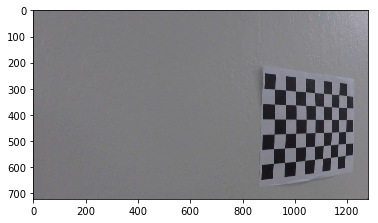

Undistorted


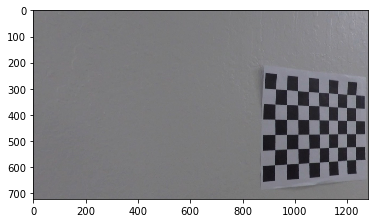

Processing:  ../camera_cal/calibration16.jpg


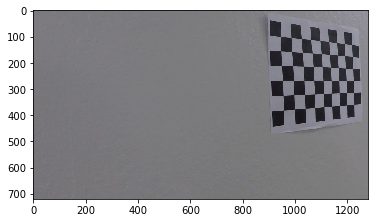

Undistorted


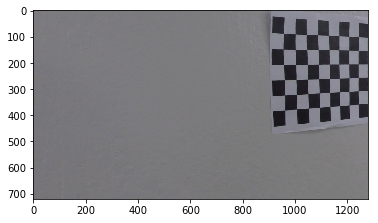

Processing:  ../camera_cal/calibration17.jpg


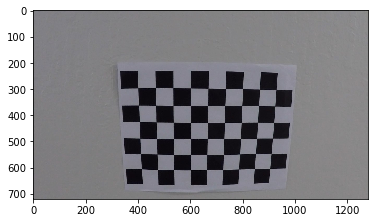

Undistorted


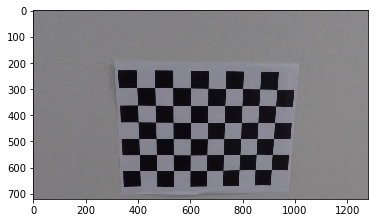

Processing:  ../camera_cal/calibration18.jpg


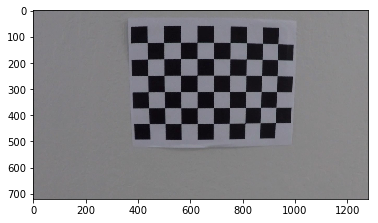

Undistorted


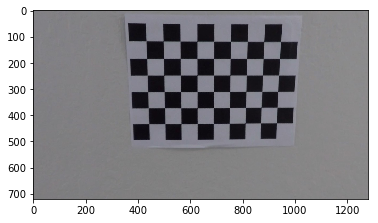

Processing:  ../camera_cal/calibration19.jpg


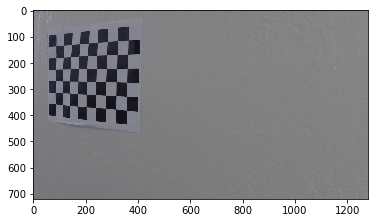

Undistorted


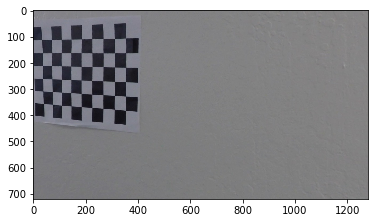

Processing:  ../camera_cal/calibration2.jpg


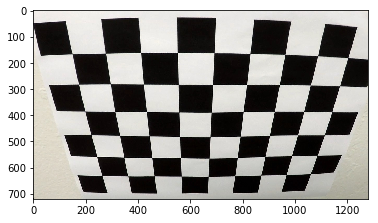

Undistorted


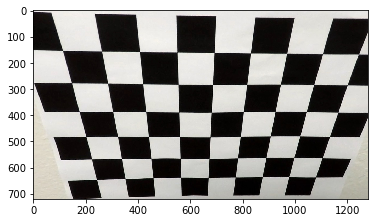

Processing:  ../camera_cal/calibration20.jpg


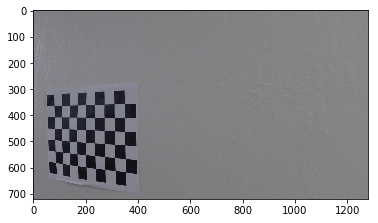

Undistorted


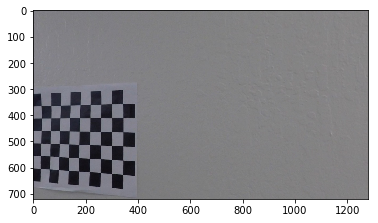

Processing:  ../camera_cal/calibration3.jpg


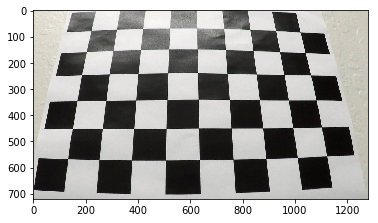

Undistorted


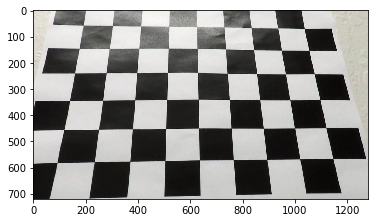

Processing:  ../camera_cal/calibration4.jpg


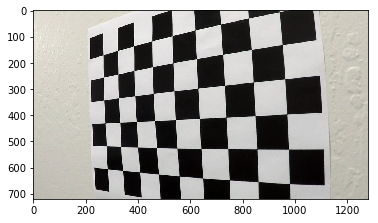

Undistorted


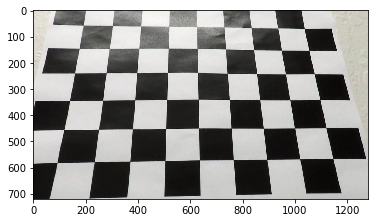

Processing:  ../camera_cal/calibration5.jpg


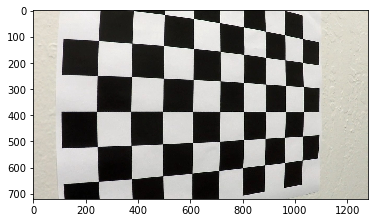

Undistorted


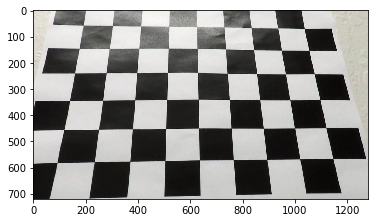

Processing:  ../camera_cal/calibration6.jpg


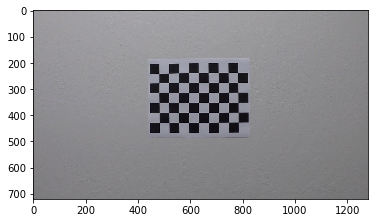

Undistorted


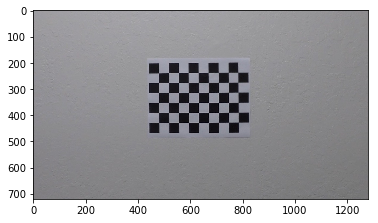

Processing:  ../camera_cal/calibration7.jpg


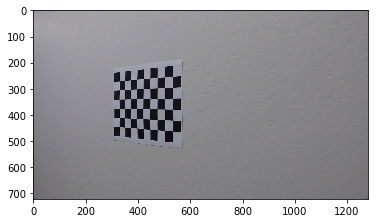

Undistorted


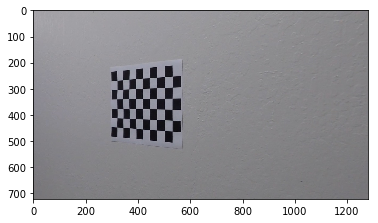

Processing:  ../camera_cal/calibration8.jpg


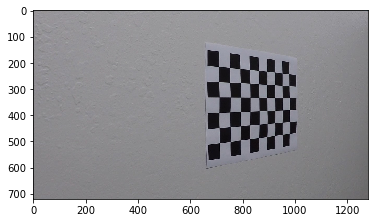

Undistorted


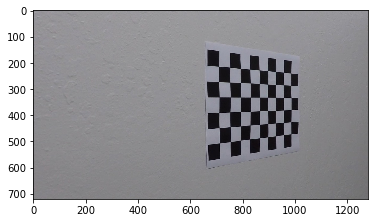

Processing:  ../camera_cal/calibration9.jpg


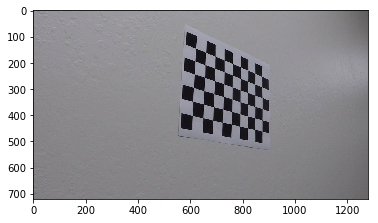

Undistorted


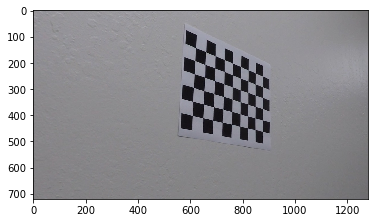

In [153]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

# Helper functions for showing images
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def gimshow(img):
    plt.imshow(img, cmap='gray')
    plt.show()


nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('../camera_cal/calibration*.jpg')

for fname in images:
    print("Processing: ", fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        ret_calib, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        
    imshow(img)
    print("Undistorted")
    imshow(dst)


## Helper Functions for Saving Images

In [193]:
import matplotlib.image as mpimg

def save(path, img):
    if not video_pipeline:
        mpimg.imsave(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR), format='jpg')

def gsave(path, img):
    if not video_pipeline:
        mpimg.imsave(path, img, format='jpg', cmap='gray')


## Helper functions for Color Space Conversion and Binary Thresholding

In [155]:
def to_bin(image, thresh):
    binary = np.zeros_like(image)
    binary[(image >= thresh[0]) & (image <= thresh[1])] = 1.0
    return binary

def combine_bin(binary_images):
    binary = np.zeros_like(binary_images[0])
    for bin_image in binary_images:
        binary[(bin_image == 1)] = 1.0
    return binary

def abs_sobel_bin(image, orient='x', thresh=(50, 255), sobel_kernel=3):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return to_bin(scaled_sobel, thresh)

def hls(image):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    return hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]

def hsv(image):
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    return hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]

def s_bin(image, thresh=(50, 255)):
    return to_bin(image, thresh)

def apply_sobel_xy(img, sobel_kernel_val=5):
    img_x = abs_sobel_bin(img, sobel_kernel=sobel_kernel_val, orient = 'x')
    img_y = abs_sobel_bin(img, sobel_kernel=sobel_kernel_val, orient = 'y')
    return combine_bin([img_x, img_y])

    

## Undistortion and Perspective Transform

In [165]:

def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

def perspective_transform(image):
    offset = 100 # Revisit
    img_size = (image.shape[1], image.shape[0])
    
    # x and y co-ordinates
#     src = np.float32([(589, 450), (200, 690), (1100, 690), (693, 450)])    
#     dst = np.float32([(230 , 0), (230, 700), (1070, 700), (1070, 0)])    

    src = np.float32([(589, 450), (200, 700), (1175, 700), (693, 450)])    
    dst = np.float32([(210 , 0), (210, 700), (1070, 700), (1070, 0)])    

#     src = np.float32([(585, 460), (203, 720), (1127, 720), (695, 460)])    
#     dst = np.float32([(320, 0), (320, 720), (960, 720), (960, 0)])    

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, img_size)
    return warped, Minv



# Line Finder

In [194]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def bound(curr_center, prev_center, window_width):
    if curr_center > prev_center and curr_center > prev_center + window_width:
        return prev_center + window_width
    if curr_center < prev_center and curr_center < prev_center - window_width:
        return prev_center - window_width
    
    return curr_center

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        
        # Don't let lcenter and rcenter go more than prev_center +/- window_width
        l_center = bound(l_center, window_centroids[-1][0], window_width)
        r_center = bound(r_center, window_centroids[-1][1], window_width)
        
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


def draw_line(warped, window_width = 50, window_height = 40, margin = 100):
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    return output, window_centroids

def calc_fitx(left_fit, right_fit, ploty):
    return left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2], right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

def fit_lines(perspective_transformed, window_width, window_height, x_centers):
    max_y = perspective_transformed.shape[0]
    ploty = np.array([max_y - window_height/2 - window_height*i for i in range(0, len(x_centers))])
    leftx = np.array([x[0] for x in x_centers])
    rightx = np.array([x[1] for x in x_centers])
    
    ploty = ploty[::-1]
    leftx = leftx[::-1]
    rightx = rightx[::-1]
    
    left_fit, right_fit = np.polyfit(ploty, leftx, 2), np.polyfit(ploty, rightx, 2)
    left_fitx, right_fitx = calc_fitx(left_fit, right_fit, ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curverad, right_curverad

def x_at(coeff, y):
    return coeff[0]*y**2 + coeff[1]*y + coeff[2]

def fit_lines_cont(perspective_transformed, left_fit, right_fit, ploty):
    nonzero = perspective_transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
#     print("Leftx length: ", len(leftx), "Lefty length: ", len(lefty))
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, perspective_transformed.shape[0]-1, perspective_transformed.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curverad, right_curverad
    
    
def overlay(undist_image, perspective_transformed, left_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(perspective_transformed).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_image.shape[1], undist_image.shape[0])) 
    save("../output_images/fill_poly.jpg", newwarp)
    
#     plt.imshow(newwarp)
#     plt.show()
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    return result


## Pipeline Definition

In [191]:
prev_lines = []
all_lines = []
    
class Line():
    def __init__(self):
        self.car_offset = None 
        self.roc = None
        self.x_dist = None
        self.left_fit_coeff = None
        self.right_fit_coeff = None
        self.left_fitx = None
        self.right_fitx = None
        self.ploty = None
        self.Minv = None
        self.perspective_transformed = None
        self.sane = False
        
def is_sane_line(line, prev_lines):
    if line.roc < 100 or line.roc > 4000: return False
    
    prev_sane_lines = np.array([p for p in prev_lines if p.sane])
    
    if len(prev_sane_lines) > 0:
        avg_x_dist = np.mean([np.mean(p.x_dist) for p in prev_sane_lines])
        curr_line_x_dist = np.mean(line.x_dist)
        if abs(curr_line_x_dist - avg_x_dist) > 0.1*avg_x_dist: return False
        
        misses = []
        splits = 10
        for i in range(0, splits):
            avg_split_x_dist = np.mean([np.mean(np.array_split(p.x_dist, splits)[i]) for p in prev_sane_lines])
            curr_line_split_x_dist = np.mean(np.array_split(line.x_dist, 10)[i])
            
            if abs(curr_line_split_x_dist - avg_split_x_dist) > 0.1*avg_split_x_dist:
                misses.append(i)
                
        if len(misses) > splits/4:
            return False
        
        if splits-1 in misses or splits-2 in misses:
            return False
    
    return True


video_pipeline = False

def pipeline(image):
    undist_image = undistort(image)
    save("../output_images/undist.jpg", undist_image)
    
    h_img, l_img, s_img = hls(undist_image)
    s_bin_img = s_bin(s_img, (90, 255))
    h2_img, s2_img, v_img = hsv(undist_image)
    l_img_sobel, s_img_sobel = apply_sobel_xy(l_img), apply_sobel_xy(s_img)
    s2_img_sobel, v_img_sobel = apply_sobel_xy(s2_img), apply_sobel_xy(v_img)
    combined_sobel = combine_bin([l_img_sobel, s_img_sobel, v_img_sobel, s2_img_sobel])

    combined = combine_bin([s_bin_img, combined_sobel])
    gsave("../output_images/bin_flt.jpg", combined)
    
    perspective_transformed, Minv = perspective_transform(image=combined)
    gsave("../output_images/persp.jpg", perspective_transformed)
    
    window_width, window_height = 50, 80
    with_line, x_centers = draw_line(perspective_transformed, window_width, window_height)
    
    save("../output_images/with_line.jpg", with_line)
    
    if len(all_lines) == 0 or len(prev_lines) == 0:
        left_fitx, right_fitx, ploty, left_fit_coeff, right_fit_coeff, left_roc, right_roc = fit_lines(perspective_transformed, window_width, window_height, x_centers)
    else:
        prev_sane_line = prev_lines[-1]
        left_fitx, right_fitx, ploty, left_fit_coeff, right_fit_coeff, left_roc, right_roc = fit_lines_cont(perspective_transformed, prev_sane_line.left_fit_coeff, prev_sane_line.right_fit_coeff, prev_sane_line.ploty)
    
    x_dist = right_fitx - left_fitx
    min_x_dist, max_x_dist, mean_x_dist = np.min(x_dist), np.max(x_dist), np.mean(x_dist)
    
    image_center_x = (image.shape[1]) / 2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_bottom_x = x_at(left_fit_coeff, image.shape[0]-1)
    right_bottom_x = x_at(right_fit_coeff, image.shape[0]-1)
    lane_center_x = (left_bottom_x + right_bottom_x)/2
    car_offset = abs(lane_center_x - image_center_x) * xm_per_pix
    
#     print("Image center:", image_center_x, ", Lane Center:", lane_center_x)
    
    curr_line = Line()
    curr_line.roc = (left_roc + right_roc) / 2
    curr_line.x_dist = x_dist
    curr_line.left_fit_coeff = left_fit_coeff
    curr_line.right_fit_coeff = right_fit_coeff
    curr_line.left_fitx = left_fitx
    curr_line.right_fitx = right_fitx
    curr_line.ploty = ploty
    curr_line.Minv = Minv
    curr_line.perspective_transformed = perspective_transformed
    curr_line.sane = is_sane_line(curr_line, prev_lines)
    curr_line.car_offset = car_offset
    
    roc = curr_line.roc

    if video_pipeline:
        if curr_line.sane or len(prev_lines) == 0:
            result = overlay(undist_image, perspective_transformed, left_fitx, right_fitx, ploty, Minv)
        else:
            prev_sane_line = prev_lines[-1]
            
            result = overlay(undist_image, prev_sane_line.perspective_transformed, prev_sane_line.left_fitx, prev_sane_line.right_fitx, prev_sane_line.ploty, prev_sane_line.Minv)
            roc = prev_sane_line.roc
            left_bottom_x = x_at(prev_sane_line.left_fit_coeff, image.shape[0]-1)
            right_bottom_x = x_at(prev_sane_line.right_fit_coeff, image.shape[0]-1)
            lane_center_x = (left_bottom_x + right_bottom_x)/2
            car_offset = abs(image_center_x - lane_center_x) * xm_per_pix            

        if curr_line.sane:
            prev_lines.append(curr_line)
            
        all_lines.append(curr_line)
    else:
        result = overlay(undist_image, perspective_transformed, left_fitx, right_fitx, ploty, Minv)
        
    cv2.putText(result, "Radius of Curvature: " + str(roc) + " m", (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, "Car offset from lane center: " + str(car_offset) + " m", (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    if not video_pipeline:
        save("../output_images/result.jpg", result)
        print("Coeff: ", left_fit_coeff, right_fit_coeff)
        print("Roc: ", left_roc, right_roc)
        print("X dist: ", min_x_dist, max_x_dist, mean_x_dist)
        print("Vehicle distance from center (m): ", curr_line.car_offset)
        
    return result


## Load and Process Test Images

Processing:  ../test_images/test3.jpg
Image center: 640.0 , Lane Center: 637.685794271
Coeff:  [  2.56358225e-04  -5.52077922e-01   5.32697186e+02] [  3.31101190e-04  -6.28392857e-01   1.28773929e+03]
Roc:  641.254292599 496.381427704
X dist:  735.568831169 752.109090909 740.444444444
Vehicle distance from center (m):  0.0122322302827


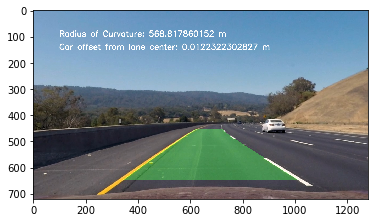

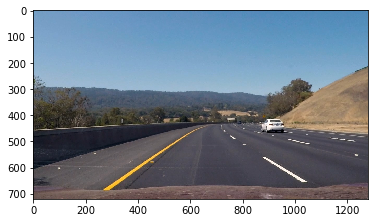

In [195]:
import os
import matplotlib.image as mpimg

test_dir = "../test_images/"

video_pipeline = False

def processImage(imgPath):
    print("Processing: ", test_dir + imgPath)
    return pipeline(cv2.imread(test_dir + imgPath))

def processTestImages():
    for imgPath in os.listdir(test_dir):
        # Got some .DS_Store files in this folder
        if(not imgPath.endswith("jpg")): continue
        if(imgPath.startswith("op-")): continue
        output = processImage(imgPath)
        cvt_output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
        mpimg.imsave(test_dir + "op-" + imgPath, cvt_output, format='jpg')
        
# processTestImages()
test_image_path = 'test3.jpg'
op = processImage(test_image_path)
# mpimg.imsave(test_dir + "op-" + test_image_path, op, format='jpg', cmap='gray')
# cv2.imwrite(test_dir + "op-" + test_image_path, op)
imshow(op)
imshow(cv2.imread(test_dir + test_image_path))
# imshow(perspective_transformed(cv2.imread(test_dir + test_image_path)))


# Process Video

In [196]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_pipeline = True
prev_lines = []
all_lines = []

# 10 -> 30
# 35 -> 50

white_output = '../project_video_op.mp4'
clip1 = VideoFileClip("../project_video.mp4")

# clip1 = VideoFileClip("../challenge_video.mp4")

# cut_clip = clip1.subclip(t_start = 10, t_end = 30)
# cut_clip = clip1.subclip(t_start = 35, t_end = 50)
# white_clip = cut_clip.fl_image(pipeline) #NOTE: this function expects color images!!

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

print("Total lines: ", len(all_lines))
print("Sane lines: ", len(prev_lines))

Image center: 640.0 , Lane Center: 676.58531901
[MoviePy] >>>> Building video ../project_video_op.mp4
[MoviePy] Writing video ../project_video_op.mp4


  0%|          | 1/1261 [00:00<10:21,  2.03it/s]

Image center: 640.0 , Lane Center: 687.541661388


  0%|          | 2/1261 [00:01<10:31,  1.99it/s]

Image center: 640.0 , Lane Center: 685.776287909


  0%|          | 3/1261 [00:01<10:49,  1.94it/s]

Image center: 640.0 , Lane Center: 681.467468293


  0%|          | 4/1261 [00:02<10:20,  2.02it/s]

Image center: 640.0 , Lane Center: 680.272771002


  0%|          | 5/1261 [00:02<10:07,  2.07it/s]

Image center: 640.0 , Lane Center: 681.990927243


  0%|          | 6/1261 [00:02<10:02,  2.08it/s]

Image center: 640.0 , Lane Center: 681.45258386


  1%|          | 7/1261 [00:03<09:52,  2.12it/s]

Image center: 640.0 , Lane Center: 683.155138177


  1%|          | 8/1261 [00:03<09:47,  2.13it/s]

Image center: 640.0 , Lane Center: 686.058229556


  1%|          | 9/1261 [00:04<09:41,  2.15it/s]

Image center: 640.0 , Lane Center: 689.333868596


  1%|          | 10/1261 [00:04<09:39,  2.16it/s]

Image center: 640.0 , Lane Center: 694.052038468


  1%|          | 11/1261 [00:05<09:39,  2.16it/s]

Image center: 640.0 , Lane Center: 698.071171262


  1%|          | 12/1261 [00:05<09:39,  2.16it/s]

Image center: 640.0 , Lane Center: 694.623860443


  1%|          | 13/1261 [00:06<09:42,  2.14it/s]

Image center: 640.0 , Lane Center: 695.591251139


  1%|          | 14/1261 [00:06<09:47,  2.12it/s]

Image center: 640.0 , Lane Center: 694.021093386


  1%|          | 15/1261 [00:07<09:55,  2.09it/s]

Image center: 640.0 , Lane Center: 687.822093414


  1%|▏         | 16/1261 [00:07<10:06,  2.05it/s]

Image center: 640.0 , Lane Center: 677.443051246


  1%|▏         | 17/1261 [00:08<10:12,  2.03it/s]

Image center: 640.0 , Lane Center: 674.402402925


  1%|▏         | 18/1261 [00:08<10:07,  2.05it/s]

Image center: 640.0 , Lane Center: 673.596284412


  2%|▏         | 19/1261 [00:09<09:59,  2.07it/s]

Image center: 640.0 , Lane Center: 671.957715961


  2%|▏         | 20/1261 [00:09<09:40,  2.14it/s]

Image center: 640.0 , Lane Center: 667.23505012


  2%|▏         | 21/1261 [00:10<09:42,  2.13it/s]

Image center: 640.0 , Lane Center: 662.630502814


  2%|▏         | 22/1261 [00:10<09:43,  2.12it/s]

Image center: 640.0 , Lane Center: 663.684959522


  2%|▏         | 23/1261 [00:10<09:42,  2.12it/s]

Image center: 640.0 , Lane Center: 663.29196758


  2%|▏         | 24/1261 [00:11<09:38,  2.14it/s]

Image center: 640.0 , Lane Center: 671.482317735


  2%|▏         | 25/1261 [00:11<09:36,  2.14it/s]

Image center: 640.0 , Lane Center: 676.752910473


  2%|▏         | 26/1261 [00:12<09:39,  2.13it/s]

Image center: 640.0 , Lane Center: 675.689450636


  2%|▏         | 27/1261 [00:12<09:33,  2.15it/s]

Image center: 640.0 , Lane Center: 674.513920531


  2%|▏         | 28/1261 [00:13<09:30,  2.16it/s]

Image center: 640.0 , Lane Center: 673.53816714


  2%|▏         | 29/1261 [00:13<09:27,  2.17it/s]

Image center: 640.0 , Lane Center: 669.482242798


  2%|▏         | 30/1261 [00:14<09:10,  2.24it/s]

Image center: 640.0 , Lane Center: 664.836793179


  2%|▏         | 31/1261 [00:14<09:18,  2.20it/s]

Image center: 640.0 , Lane Center: 660.261387602


  3%|▎         | 32/1261 [00:15<09:20,  2.19it/s]

Image center: 640.0 , Lane Center: 657.375168405


  3%|▎         | 33/1261 [00:15<09:23,  2.18it/s]

Image center: 640.0 , Lane Center: 652.727834132


  3%|▎         | 34/1261 [00:16<09:26,  2.17it/s]

Image center: 640.0 , Lane Center: 659.725751944


  3%|▎         | 35/1261 [00:16<09:28,  2.16it/s]

Image center: 640.0 , Lane Center: 669.521422358


  3%|▎         | 36/1261 [00:16<09:28,  2.16it/s]

Image center: 640.0 , Lane Center: 679.668071327


  3%|▎         | 37/1261 [00:17<09:30,  2.15it/s]

Image center: 640.0 , Lane Center: 678.490166835


  3%|▎         | 38/1261 [00:17<09:35,  2.13it/s]

Image center: 640.0 , Lane Center: 670.330084311


  3%|▎         | 39/1261 [00:18<09:33,  2.13it/s]

Image center: 640.0 , Lane Center: 661.154613019


  3%|▎         | 40/1261 [00:18<09:30,  2.14it/s]

Image center: 640.0 , Lane Center: 661.702345046


  3%|▎         | 41/1261 [00:19<09:23,  2.16it/s]

Image center: 640.0 , Lane Center: 663.497006822


  3%|▎         | 42/1261 [00:19<09:23,  2.16it/s]

Image center: 640.0 , Lane Center: 667.841679197


  3%|▎         | 43/1261 [00:20<09:39,  2.10it/s]

Image center: 640.0 , Lane Center: 671.293691194


  3%|▎         | 44/1261 [00:20<09:55,  2.04it/s]

Image center: 640.0 , Lane Center: 671.802799163


  4%|▎         | 45/1261 [00:21<09:47,  2.07it/s]

Image center: 640.0 , Lane Center: 670.153610088


  4%|▎         | 46/1261 [00:21<09:31,  2.13it/s]

Image center: 640.0 , Lane Center: 671.056915104


  4%|▎         | 47/1261 [00:22<09:39,  2.09it/s]

Image center: 640.0 , Lane Center: 674.050195346


  4%|▍         | 48/1261 [00:22<09:42,  2.08it/s]

Image center: 640.0 , Lane Center: 686.219591179


  4%|▍         | 49/1261 [00:23<09:21,  2.16it/s]

Image center: 640.0 , Lane Center: 687.607697846


  4%|▍         | 50/1261 [00:23<09:19,  2.16it/s]

Image center: 640.0 , Lane Center: 692.570507662


  4%|▍         | 51/1261 [00:23<09:19,  2.16it/s]

Image center: 640.0 , Lane Center: 690.780368536


  4%|▍         | 52/1261 [00:24<09:22,  2.15it/s]

Image center: 640.0 , Lane Center: 683.49411519


  4%|▍         | 53/1261 [00:24<09:24,  2.14it/s]

Image center: 640.0 , Lane Center: 675.523768563


  4%|▍         | 54/1261 [00:25<09:20,  2.15it/s]

Image center: 640.0 , Lane Center: 675.112646411


  4%|▍         | 55/1261 [00:25<09:17,  2.16it/s]

Image center: 640.0 , Lane Center: 674.980178826


  4%|▍         | 56/1261 [00:26<09:23,  2.14it/s]

Image center: 640.0 , Lane Center: 674.596900767


  5%|▍         | 57/1261 [00:26<09:21,  2.14it/s]

Image center: 640.0 , Lane Center: 673.480607361


  5%|▍         | 58/1261 [00:27<09:11,  2.18it/s]

Image center: 640.0 , Lane Center: 673.309157856


  5%|▍         | 59/1261 [00:27<08:59,  2.23it/s]

Image center: 640.0 , Lane Center: 686.222957973


  5%|▍         | 60/1261 [00:28<09:11,  2.18it/s]

Image center: 640.0 , Lane Center: 685.964104962


  5%|▍         | 61/1261 [00:28<09:10,  2.18it/s]

Image center: 640.0 , Lane Center: 671.367193488


  5%|▍         | 62/1261 [00:29<09:12,  2.17it/s]

Image center: 640.0 , Lane Center: 656.444185135


  5%|▍         | 63/1261 [00:29<09:17,  2.15it/s]

Image center: 640.0 , Lane Center: 651.37886628


  5%|▌         | 64/1261 [00:30<09:22,  2.13it/s]

Image center: 640.0 , Lane Center: 653.022238592


  5%|▌         | 65/1261 [00:30<09:10,  2.17it/s]

Image center: 640.0 , Lane Center: 654.163030241


  5%|▌         | 66/1261 [00:30<09:05,  2.19it/s]

Image center: 640.0 , Lane Center: 657.122082352


  5%|▌         | 67/1261 [00:31<09:10,  2.17it/s]

Image center: 640.0 , Lane Center: 658.250418681


  5%|▌         | 68/1261 [00:31<09:21,  2.13it/s]

Image center: 640.0 , Lane Center: 655.753778398


  5%|▌         | 69/1261 [00:32<09:09,  2.17it/s]

Image center: 640.0 , Lane Center: 658.403878517


  6%|▌         | 70/1261 [00:32<09:27,  2.10it/s]

Image center: 640.0 , Lane Center: 659.132600755


  6%|▌         | 71/1261 [00:33<09:33,  2.08it/s]

Image center: 640.0 , Lane Center: 660.94204839


  6%|▌         | 72/1261 [00:33<09:38,  2.05it/s]

Image center: 640.0 , Lane Center: 658.316282064


  6%|▌         | 73/1261 [00:34<09:26,  2.10it/s]

Image center: 640.0 , Lane Center: 651.814713538


  6%|▌         | 74/1261 [00:34<09:15,  2.14it/s]

Image center: 640.0 , Lane Center: 645.211891954


  6%|▌         | 75/1261 [00:35<09:10,  2.15it/s]

Image center: 640.0 , Lane Center: 645.71640477


  6%|▌         | 76/1261 [00:35<09:19,  2.12it/s]

Image center: 640.0 , Lane Center: 638.746161911


  6%|▌         | 77/1261 [00:36<09:06,  2.17it/s]

Image center: 640.0 , Lane Center: 644.557990974


  6%|▌         | 78/1261 [00:36<09:11,  2.14it/s]

Image center: 640.0 , Lane Center: 644.874952931


  6%|▋         | 79/1261 [00:37<09:18,  2.12it/s]

Image center: 640.0 , Lane Center: 642.311214562


  6%|▋         | 80/1261 [00:37<09:25,  2.09it/s]

Image center: 640.0 , Lane Center: 641.597043573


  6%|▋         | 81/1261 [00:38<09:10,  2.14it/s]

Image center: 640.0 , Lane Center: 638.94615594


  7%|▋         | 82/1261 [00:38<08:58,  2.19it/s]

Image center: 640.0 , Lane Center: 637.254098723


  7%|▋         | 83/1261 [00:38<08:52,  2.21it/s]

Image center: 640.0 , Lane Center: 635.7189802


  7%|▋         | 84/1261 [00:39<08:58,  2.19it/s]

Image center: 640.0 , Lane Center: 628.964102451


  7%|▋         | 85/1261 [00:39<08:51,  2.21it/s]

Image center: 640.0 , Lane Center: 635.412335695


  7%|▋         | 86/1261 [00:40<08:59,  2.18it/s]

Image center: 640.0 , Lane Center: 640.486154613


  7%|▋         | 87/1261 [00:40<09:01,  2.17it/s]

Image center: 640.0 , Lane Center: 646.151318391


  7%|▋         | 88/1261 [00:41<09:08,  2.14it/s]

Image center: 640.0 , Lane Center: 639.310715794


  7%|▋         | 89/1261 [00:41<09:13,  2.12it/s]

Image center: 640.0 , Lane Center: 626.542385901


  7%|▋         | 90/1261 [00:42<09:17,  2.10it/s]

Image center: 640.0 , Lane Center: 628.689691667


  7%|▋         | 91/1261 [00:42<09:04,  2.15it/s]

Image center: 640.0 , Lane Center: 632.08483878


  7%|▋         | 92/1261 [00:43<09:15,  2.10it/s]

Image center: 640.0 , Lane Center: 633.777560881


  7%|▋         | 93/1261 [00:43<09:16,  2.10it/s]

Image center: 640.0 , Lane Center: 636.519633219


  7%|▋         | 94/1261 [00:44<09:24,  2.07it/s]

Image center: 640.0 , Lane Center: 639.493099441


  8%|▊         | 95/1261 [00:44<09:39,  2.01it/s]

Image center: 640.0 , Lane Center: 638.742687602


  8%|▊         | 96/1261 [00:45<09:43,  2.00it/s]

Image center: 640.0 , Lane Center: 642.760963445


  8%|▊         | 97/1261 [00:45<09:53,  1.96it/s]

Image center: 640.0 , Lane Center: 647.533345606


  8%|▊         | 98/1261 [00:46<10:05,  1.92it/s]

Image center: 640.0 , Lane Center: 648.205799541


  8%|▊         | 99/1261 [00:46<10:07,  1.91it/s]

Image center: 640.0 , Lane Center: 650.620120594


  8%|▊         | 100/1261 [00:47<09:59,  1.94it/s]

Image center: 640.0 , Lane Center: 645.387479737


  8%|▊         | 101/1261 [00:47<09:53,  1.95it/s]

Image center: 640.0 , Lane Center: 638.386133932


  8%|▊         | 102/1261 [00:48<09:46,  1.98it/s]

Image center: 640.0 , Lane Center: 628.72108718


  8%|▊         | 103/1261 [00:48<09:39,  2.00it/s]

Image center: 640.0 , Lane Center: 632.34228906


  8%|▊         | 104/1261 [00:49<09:25,  2.05it/s]

Image center: 640.0 , Lane Center: 632.004019876


  8%|▊         | 105/1261 [00:49<09:23,  2.05it/s]

Image center: 640.0 , Lane Center: 634.644529646


  8%|▊         | 106/1261 [00:50<09:22,  2.05it/s]

Image center: 640.0 , Lane Center: 635.780848192


  8%|▊         | 107/1261 [00:50<09:33,  2.01it/s]

Image center: 640.0 , Lane Center: 635.569835199


  9%|▊         | 108/1261 [00:51<09:37,  2.00it/s]

Image center: 640.0 , Lane Center: 635.166497964


  9%|▊         | 109/1261 [00:51<09:41,  1.98it/s]

Image center: 640.0 , Lane Center: 638.038555394


  9%|▊         | 110/1261 [00:52<09:38,  1.99it/s]

Image center: 640.0 , Lane Center: 645.469652173


  9%|▉         | 111/1261 [00:52<09:29,  2.02it/s]

Image center: 640.0 , Lane Center: 653.144925544


  9%|▉         | 112/1261 [00:53<09:36,  1.99it/s]

Image center: 640.0 , Lane Center: 655.199189773


  9%|▉         | 113/1261 [00:53<09:33,  2.00it/s]

Image center: 640.0 , Lane Center: 656.299877498


  9%|▉         | 114/1261 [00:54<09:16,  2.06it/s]

Image center: 640.0 , Lane Center: 657.691789773


  9%|▉         | 115/1261 [00:54<09:22,  2.04it/s]

Image center: 640.0 , Lane Center: 652.318024482


  9%|▉         | 116/1261 [00:55<09:28,  2.01it/s]

Image center: 640.0 , Lane Center: 644.773791799


  9%|▉         | 117/1261 [00:55<09:30,  2.00it/s]

Image center: 640.0 , Lane Center: 648.31253187


  9%|▉         | 118/1261 [00:56<09:16,  2.06it/s]

Image center: 640.0 , Lane Center: 651.991544517


  9%|▉         | 119/1261 [00:56<09:18,  2.05it/s]

Image center: 640.0 , Lane Center: 655.390645676


 10%|▉         | 120/1261 [00:57<09:27,  2.01it/s]

Image center: 640.0 , Lane Center: 663.269180813


 10%|▉         | 121/1261 [00:57<09:26,  2.01it/s]

Image center: 640.0 , Lane Center: 669.556518282


 10%|▉         | 122/1261 [00:58<09:26,  2.01it/s]

Image center: 640.0 , Lane Center: 677.418731418


 10%|▉         | 123/1261 [00:58<09:46,  1.94it/s]

Image center: 640.0 , Lane Center: 675.074939662


 10%|▉         | 124/1261 [00:59<09:59,  1.90it/s]

Image center: 640.0 , Lane Center: 661.366786494


 10%|▉         | 125/1261 [00:59<10:50,  1.75it/s]

Image center: 640.0 , Lane Center: 656.85456498


 10%|▉         | 126/1261 [01:00<10:44,  1.76it/s]

Image center: 640.0 , Lane Center: 658.638823979


 10%|█         | 127/1261 [01:00<10:25,  1.81it/s]

Image center: 640.0 , Lane Center: 659.668870524
Image center: 640.0 , Lane Center: 662.650218651


 10%|█         | 129/1261 [01:02<11:29,  1.64it/s]

Image center: 640.0 , Lane Center: 668.970027808


 10%|█         | 130/1261 [01:03<12:32,  1.50it/s]

Image center: 640.0 , Lane Center: 670.367314522


 10%|█         | 131/1261 [01:03<12:43,  1.48it/s]

Image center: 640.0 , Lane Center: 674.273281414


 10%|█         | 132/1261 [01:04<12:56,  1.45it/s]

Image center: 640.0 , Lane Center: 679.18982406


 11%|█         | 133/1261 [01:05<12:32,  1.50it/s]

Image center: 640.0 , Lane Center: 684.617389428


 11%|█         | 134/1261 [01:05<12:52,  1.46it/s]

Image center: 640.0 , Lane Center: 691.445518539


 11%|█         | 135/1261 [01:06<12:13,  1.54it/s]

Image center: 640.0 , Lane Center: 686.134710522


 11%|█         | 136/1261 [01:06<11:36,  1.62it/s]

Image center: 640.0 , Lane Center: 684.377978475


 11%|█         | 137/1261 [01:07<11:14,  1.67it/s]

Image center: 640.0 , Lane Center: 682.603478425


 11%|█         | 138/1261 [01:08<10:40,  1.75it/s]

Image center: 640.0 , Lane Center: 684.08527545


 11%|█         | 139/1261 [01:08<10:11,  1.83it/s]

Image center: 640.0 , Lane Center: 677.121704389


 11%|█         | 140/1261 [01:09<11:35,  1.61it/s]

Image center: 640.0 , Lane Center: 680.445379928


 11%|█         | 141/1261 [01:09<11:02,  1.69it/s]

Image center: 640.0 , Lane Center: 672.325639789


 11%|█▏        | 142/1261 [01:10<10:36,  1.76it/s]

Image center: 640.0 , Lane Center: 670.247719438


 11%|█▏        | 143/1261 [01:10<10:25,  1.79it/s]

Image center: 640.0 , Lane Center: 673.064293735


 11%|█▏        | 144/1261 [01:11<09:58,  1.87it/s]

Image center: 640.0 , Lane Center: 673.06472432


 11%|█▏        | 145/1261 [01:11<09:47,  1.90it/s]

Image center: 640.0 , Lane Center: 674.091838423


 12%|█▏        | 146/1261 [01:12<09:40,  1.92it/s]

Image center: 640.0 , Lane Center: 679.388156968


 12%|█▏        | 147/1261 [01:12<10:04,  1.84it/s]

Image center: 640.0 , Lane Center: 683.941844276


 12%|█▏        | 148/1261 [01:13<10:07,  1.83it/s]

Image center: 640.0 , Lane Center: 682.229276337


 12%|█▏        | 149/1261 [01:14<09:36,  1.93it/s]

Image center: 640.0 , Lane Center: 663.690722212


 12%|█▏        | 150/1261 [01:14<09:44,  1.90it/s]

Image center: 640.0 , Lane Center: 661.183545853


 12%|█▏        | 151/1261 [01:15<10:55,  1.69it/s]

Image center: 640.0 , Lane Center: 659.19871256


 12%|█▏        | 152/1261 [01:15<10:24,  1.77it/s]

Image center: 640.0 , Lane Center: 657.902821039


 12%|█▏        | 153/1261 [01:16<09:49,  1.88it/s]

Image center: 640.0 , Lane Center: 660.576319011


 12%|█▏        | 154/1261 [01:16<09:22,  1.97it/s]

Image center: 640.0 , Lane Center: 662.573765375


 12%|█▏        | 155/1261 [01:17<09:03,  2.04it/s]

Image center: 640.0 , Lane Center: 663.864276112


 12%|█▏        | 156/1261 [01:17<09:19,  1.98it/s]

Image center: 640.0 , Lane Center: 664.390415834


 12%|█▏        | 157/1261 [01:18<09:02,  2.04it/s]

Image center: 640.0 , Lane Center: 666.726899712


 13%|█▎        | 158/1261 [01:18<08:50,  2.08it/s]

Image center: 640.0 , Lane Center: 673.178908777


 13%|█▎        | 159/1261 [01:19<09:08,  2.01it/s]

Image center: 640.0 , Lane Center: 678.245371747


 13%|█▎        | 160/1261 [01:19<09:45,  1.88it/s]

Image center: 640.0 , Lane Center: 681.621115689


 13%|█▎        | 161/1261 [01:20<09:34,  1.91it/s]

Image center: 640.0 , Lane Center: 678.327024483


 13%|█▎        | 162/1261 [01:20<09:27,  1.94it/s]

Image center: 640.0 , Lane Center: 674.133054695


 13%|█▎        | 163/1261 [01:21<09:26,  1.94it/s]

Image center: 640.0 , Lane Center: 669.075394009


 13%|█▎        | 164/1261 [01:21<10:00,  1.83it/s]

Image center: 640.0 , Lane Center: 664.793994068


 13%|█▎        | 165/1261 [01:22<10:10,  1.79it/s]

Image center: 640.0 , Lane Center: 653.690268817


 13%|█▎        | 166/1261 [01:23<11:35,  1.57it/s]

Image center: 640.0 , Lane Center: 647.929649903


 13%|█▎        | 167/1261 [01:23<11:04,  1.65it/s]

Image center: 640.0 , Lane Center: 655.564345863


 13%|█▎        | 168/1261 [01:24<11:13,  1.62it/s]

Image center: 640.0 , Lane Center: 654.854255662


 13%|█▎        | 169/1261 [01:25<11:53,  1.53it/s]

Image center: 640.0 , Lane Center: 653.053955643


 13%|█▎        | 170/1261 [01:25<10:49,  1.68it/s]

Image center: 640.0 , Lane Center: 650.266796359


 14%|█▎        | 171/1261 [01:26<10:28,  1.73it/s]

Image center: 640.0 , Lane Center: 649.496603094


 14%|█▎        | 172/1261 [01:26<11:33,  1.57it/s]

Image center: 640.0 , Lane Center: 656.080756553


 14%|█▎        | 173/1261 [01:27<10:41,  1.70it/s]

Image center: 640.0 , Lane Center: 663.246369329


 14%|█▍        | 174/1261 [01:28<10:46,  1.68it/s]

Image center: 640.0 , Lane Center: 652.997342581


 14%|█▍        | 175/1261 [01:28<10:24,  1.74it/s]

Image center: 640.0 , Lane Center: 637.963610275


 14%|█▍        | 176/1261 [01:29<10:14,  1.77it/s]

Image center: 640.0 , Lane Center: 634.904235881


 14%|█▍        | 177/1261 [01:29<10:49,  1.67it/s]

Image center: 640.0 , Lane Center: 635.067160138


 14%|█▍        | 178/1261 [01:30<10:30,  1.72it/s]

Image center: 640.0 , Lane Center: 639.708877496


 14%|█▍        | 179/1261 [01:30<10:10,  1.77it/s]

Image center: 640.0 , Lane Center: 644.228415901


 14%|█▍        | 180/1261 [01:31<09:50,  1.83it/s]

Image center: 640.0 , Lane Center: 647.701793185


 14%|█▍        | 181/1261 [01:31<09:30,  1.89it/s]

Image center: 640.0 , Lane Center: 653.844031917


 14%|█▍        | 182/1261 [01:32<09:17,  1.93it/s]

Image center: 640.0 , Lane Center: 655.730853603


 15%|█▍        | 183/1261 [01:32<09:11,  1.95it/s]

Image center: 640.0 , Lane Center: 667.433425829


 15%|█▍        | 184/1261 [01:33<09:13,  1.95it/s]

Image center: 640.0 , Lane Center: 674.491596032


 15%|█▍        | 185/1261 [01:33<09:10,  1.95it/s]

Image center: 640.0 , Lane Center: 660.965882603


 15%|█▍        | 186/1261 [01:34<08:53,  2.02it/s]

Image center: 640.0 , Lane Center: 652.000535282


 15%|█▍        | 187/1261 [01:34<09:15,  1.93it/s]

Image center: 640.0 , Lane Center: 652.912602545


 15%|█▍        | 188/1261 [01:35<09:47,  1.83it/s]

Image center: 640.0 , Lane Center: 660.930103539


 15%|█▍        | 189/1261 [01:36<10:08,  1.76it/s]

Image center: 640.0 , Lane Center: 662.024144327


 15%|█▌        | 190/1261 [01:36<10:22,  1.72it/s]

Image center: 640.0 , Lane Center: 664.058628202


 15%|█▌        | 191/1261 [01:37<10:32,  1.69it/s]

Image center: 640.0 , Lane Center: 666.16895158
Image center: 640.0 , Lane Center: 669.142595832


 15%|█▌        | 193/1261 [01:39<14:11,  1.25it/s]

Image center: 640.0 , Lane Center: 668.741451837


 15%|█▌        | 194/1261 [01:40<14:10,  1.26it/s]

Image center: 640.0 , Lane Center: 669.015038119
Image center: 640.0 , Lane Center: 663.524278542


 15%|█▌        | 195/1261 [01:40<14:20,  1.24it/s]

Image center: 640.0 , Lane Center: 679.384924429


 16%|█▌        | 197/1261 [01:42<15:19,  1.16it/s]

Image center: 640.0 , Lane Center: 672.893331382


 16%|█▌        | 198/1261 [01:43<13:49,  1.28it/s]

Image center: 640.0 , Lane Center: 666.047225714


 16%|█▌        | 199/1261 [01:44<13:02,  1.36it/s]

Image center: 640.0 , Lane Center: 662.474289637


 16%|█▌        | 200/1261 [01:44<12:44,  1.39it/s]

Image center: 640.0 , Lane Center: 669.845580565


 16%|█▌        | 201/1261 [01:45<11:59,  1.47it/s]

Image center: 640.0 , Lane Center: 671.470709249


 16%|█▌        | 202/1261 [01:45<11:31,  1.53it/s]

Image center: 640.0 , Lane Center: 669.591505831


 16%|█▌        | 203/1261 [01:46<11:08,  1.58it/s]

Image center: 640.0 , Lane Center: 663.946196033


 16%|█▌        | 204/1261 [01:47<10:55,  1.61it/s]

Image center: 640.0 , Lane Center: 659.374206722


 16%|█▋        | 205/1261 [01:47<10:24,  1.69it/s]

Image center: 640.0 , Lane Center: 654.938682219


 16%|█▋        | 206/1261 [01:48<10:24,  1.69it/s]

Image center: 640.0 , Lane Center: 654.861770673


 16%|█▋        | 207/1261 [01:48<10:24,  1.69it/s]

Image center: 640.0 , Lane Center: 664.412912474


 16%|█▋        | 208/1261 [01:49<10:55,  1.61it/s]

Image center: 640.0 , Lane Center: 673.802494161


 17%|█▋        | 209/1261 [01:50<10:34,  1.66it/s]

Image center: 640.0 , Lane Center: 678.859122074


 17%|█▋        | 210/1261 [01:50<10:14,  1.71it/s]

Image center: 640.0 , Lane Center: 679.036049987


 17%|█▋        | 211/1261 [01:51<09:41,  1.80it/s]

Image center: 640.0 , Lane Center: 673.707093382


 17%|█▋        | 212/1261 [01:51<10:08,  1.72it/s]

Image center: 640.0 , Lane Center: 673.482382364


 17%|█▋        | 213/1261 [01:52<10:17,  1.70it/s]

Image center: 640.0 , Lane Center: 670.197183269


 17%|█▋        | 214/1261 [01:52<10:15,  1.70it/s]

Image center: 640.0 , Lane Center: 663.058249684


 17%|█▋        | 215/1261 [01:53<10:00,  1.74it/s]

Image center: 640.0 , Lane Center: 654.211807139


 17%|█▋        | 216/1261 [01:53<09:31,  1.83it/s]

Image center: 640.0 , Lane Center: 653.458073869


 17%|█▋        | 217/1261 [01:54<09:05,  1.92it/s]

Image center: 640.0 , Lane Center: 654.468791299


 17%|█▋        | 218/1261 [01:54<08:54,  1.95it/s]

Image center: 640.0 , Lane Center: 653.022705609


 17%|█▋        | 219/1261 [01:55<08:51,  1.96it/s]

Image center: 640.0 , Lane Center: 657.283419096


 17%|█▋        | 220/1261 [01:55<08:53,  1.95it/s]

Image center: 640.0 , Lane Center: 654.944483794


 18%|█▊        | 221/1261 [01:56<08:53,  1.95it/s]

Image center: 640.0 , Lane Center: 661.231635578


 18%|█▊        | 222/1261 [01:56<08:40,  2.00it/s]

Image center: 640.0 , Lane Center: 663.068541614


 18%|█▊        | 223/1261 [01:57<10:03,  1.72it/s]

Image center: 640.0 , Lane Center: 665.107023581


 18%|█▊        | 224/1261 [01:58<09:54,  1.74it/s]

Image center: 640.0 , Lane Center: 660.336757338


 18%|█▊        | 225/1261 [01:58<09:50,  1.75it/s]

Image center: 640.0 , Lane Center: 648.508277809


 18%|█▊        | 226/1261 [01:59<09:35,  1.80it/s]

Image center: 640.0 , Lane Center: 637.829796982


 18%|█▊        | 227/1261 [01:59<09:42,  1.78it/s]

Image center: 640.0 , Lane Center: 636.92361996


 18%|█▊        | 228/1261 [02:00<09:13,  1.87it/s]

Image center: 640.0 , Lane Center: 639.53152335


 18%|█▊        | 229/1261 [02:00<09:00,  1.91it/s]

Image center: 640.0 , Lane Center: 639.29895113


 18%|█▊        | 230/1261 [02:01<09:03,  1.90it/s]

Image center: 640.0 , Lane Center: 637.426257827


 18%|█▊        | 231/1261 [02:02<09:19,  1.84it/s]

Image center: 640.0 , Lane Center: 638.766409027


 18%|█▊        | 232/1261 [02:02<11:05,  1.55it/s]

Image center: 640.0 , Lane Center: 636.121620429


 18%|█▊        | 233/1261 [02:03<10:32,  1.62it/s]

Image center: 640.0 , Lane Center: 640.502791633


 19%|█▊        | 234/1261 [02:04<10:57,  1.56it/s]

Image center: 640.0 , Lane Center: 644.860688654


 19%|█▊        | 235/1261 [02:04<10:54,  1.57it/s]

Image center: 640.0 , Lane Center: 646.404999491


 19%|█▊        | 236/1261 [02:05<10:49,  1.58it/s]

Image center: 640.0 , Lane Center: 635.523025464


 19%|█▉        | 237/1261 [02:05<10:19,  1.65it/s]

Image center: 640.0 , Lane Center: 622.448524249


 19%|█▉        | 238/1261 [02:06<10:07,  1.68it/s]

Image center: 640.0 , Lane Center: 619.499484315


 19%|█▉        | 239/1261 [02:07<09:41,  1.76it/s]

Image center: 640.0 , Lane Center: 623.108073443


 19%|█▉        | 240/1261 [02:07<09:46,  1.74it/s]

Image center: 640.0 , Lane Center: 627.262220379


 19%|█▉        | 241/1261 [02:08<09:15,  1.84it/s]

Image center: 640.0 , Lane Center: 628.868963462


 19%|█▉        | 242/1261 [02:08<09:38,  1.76it/s]

Image center: 640.0 , Lane Center: 629.204628545


 19%|█▉        | 243/1261 [02:09<09:51,  1.72it/s]

Image center: 640.0 , Lane Center: 632.877700707


 19%|█▉        | 244/1261 [02:09<09:38,  1.76it/s]

Image center: 640.0 , Lane Center: 632.953058489


 19%|█▉        | 245/1261 [02:10<09:26,  1.79it/s]

Image center: 640.0 , Lane Center: 630.429427997


 20%|█▉        | 246/1261 [02:10<09:03,  1.87it/s]

Image center: 640.0 , Lane Center: 615.230176699


 20%|█▉        | 247/1261 [02:11<08:58,  1.88it/s]

Image center: 640.0 , Lane Center: 609.673488187


 20%|█▉        | 248/1261 [02:11<08:46,  1.92it/s]

Image center: 640.0 , Lane Center: 613.439488655


 20%|█▉        | 249/1261 [02:12<08:41,  1.94it/s]

Image center: 640.0 , Lane Center: 613.181636301


 20%|█▉        | 250/1261 [02:12<08:40,  1.94it/s]

Image center: 640.0 , Lane Center: 616.799998146


 20%|█▉        | 251/1261 [02:13<08:24,  2.00it/s]

Image center: 640.0 , Lane Center: 618.958011629


 20%|█▉        | 252/1261 [02:13<08:30,  1.98it/s]

Image center: 640.0 , Lane Center: 619.673167477


 20%|██        | 253/1261 [02:14<08:46,  1.91it/s]

Image center: 640.0 , Lane Center: 623.497674438


 20%|██        | 254/1261 [02:15<10:14,  1.64it/s]

Image center: 640.0 , Lane Center: 625.176450742


 20%|██        | 255/1261 [02:15<09:46,  1.72it/s]

Image center: 640.0 , Lane Center: 630.360277122


 20%|██        | 256/1261 [02:16<10:14,  1.64it/s]

Image center: 640.0 , Lane Center: 634.282843198


 20%|██        | 257/1261 [02:17<10:17,  1.63it/s]

Image center: 640.0 , Lane Center: 626.550538951


 20%|██        | 258/1261 [02:17<09:38,  1.74it/s]

Image center: 640.0 , Lane Center: 616.249092279


 21%|██        | 259/1261 [02:18<10:11,  1.64it/s]

Image center: 640.0 , Lane Center: 611.97992518


 21%|██        | 260/1261 [02:18<09:40,  1.72it/s]

Image center: 640.0 , Lane Center: 611.369587748


 21%|██        | 261/1261 [02:19<09:22,  1.78it/s]

Image center: 640.0 , Lane Center: 612.965926214


 21%|██        | 262/1261 [02:19<09:07,  1.82it/s]

Image center: 640.0 , Lane Center: 612.592128486


 21%|██        | 263/1261 [02:20<08:55,  1.86it/s]

Image center: 640.0 , Lane Center: 616.452154827


 21%|██        | 264/1261 [02:20<08:52,  1.87it/s]

Image center: 640.0 , Lane Center: 618.702483801


 21%|██        | 265/1261 [02:21<08:38,  1.92it/s]

Image center: 640.0 , Lane Center: 623.331458707


 21%|██        | 266/1261 [02:21<08:31,  1.94it/s]

Image center: 640.0 , Lane Center: 624.157470256


 21%|██        | 267/1261 [02:22<08:25,  1.96it/s]

Image center: 640.0 , Lane Center: 627.391469017


 21%|██▏       | 268/1261 [02:22<09:04,  1.82it/s]

Image center: 640.0 , Lane Center: 628.819970162


 21%|██▏       | 269/1261 [02:23<09:22,  1.76it/s]

Image center: 640.0 , Lane Center: 631.718231813
Image center: 640.0 , Lane Center: 641.829594042


 21%|██▏       | 270/1261 [02:24<11:35,  1.43it/s]

Image center: 640.0 , Lane Center: 649.144214472


 21%|██▏       | 271/1261 [02:25<13:19,  1.24it/s]

Image center: 640.0 , Lane Center: 637.972549901


 22%|██▏       | 273/1261 [02:27<15:01,  1.10it/s]

Image center: 640.0 , Lane Center: 629.876868332


 22%|██▏       | 274/1261 [02:28<13:38,  1.21it/s]

Image center: 640.0 , Lane Center: 630.515002879


 22%|██▏       | 275/1261 [02:29<13:14,  1.24it/s]

Image center: 640.0 , Lane Center: 630.748192267


 22%|██▏       | 276/1261 [02:29<12:16,  1.34it/s]

Image center: 640.0 , Lane Center: 633.347976639


 22%|██▏       | 277/1261 [02:30<11:18,  1.45it/s]

Image center: 640.0 , Lane Center: 635.217284808


 22%|██▏       | 278/1261 [02:30<11:06,  1.47it/s]

Image center: 640.0 , Lane Center: 637.216850351


 22%|██▏       | 279/1261 [02:31<11:25,  1.43it/s]

Image center: 640.0 , Lane Center: 641.019608964
Image center: 640.0 , Lane Center: 645.625322623


 22%|██▏       | 281/1261 [02:33<12:30,  1.31it/s]

Image center: 640.0 , Lane Center: 655.281993751


 22%|██▏       | 282/1261 [02:33<11:20,  1.44it/s]

Image center: 640.0 , Lane Center: 646.028480852


 22%|██▏       | 283/1261 [02:34<10:29,  1.55it/s]

Image center: 640.0 , Lane Center: 647.06576655


 23%|██▎       | 284/1261 [02:35<10:14,  1.59it/s]

Image center: 640.0 , Lane Center: 639.830012297


 23%|██▎       | 285/1261 [02:35<09:46,  1.66it/s]

Image center: 640.0 , Lane Center: 641.568781668


 23%|██▎       | 286/1261 [02:36<09:37,  1.69it/s]

Image center: 640.0 , Lane Center: 643.338726492


 23%|██▎       | 287/1261 [02:36<09:41,  1.67it/s]

Image center: 640.0 , Lane Center: 641.47640848


 23%|██▎       | 288/1261 [02:37<10:35,  1.53it/s]

Image center: 640.0 , Lane Center: 646.176324473


 23%|██▎       | 289/1261 [02:38<10:07,  1.60it/s]

Image center: 640.0 , Lane Center: 647.607616791


 23%|██▎       | 290/1261 [02:38<09:49,  1.65it/s]

Image center: 640.0 , Lane Center: 648.990425948


 23%|██▎       | 291/1261 [02:39<09:30,  1.70it/s]

Image center: 640.0 , Lane Center: 653.577274524


 23%|██▎       | 292/1261 [02:39<09:22,  1.72it/s]

Image center: 640.0 , Lane Center: 658.934618057


 23%|██▎       | 293/1261 [02:40<09:55,  1.62it/s]

Image center: 640.0 , Lane Center: 665.409610103


 23%|██▎       | 294/1261 [02:41<10:01,  1.61it/s]

Image center: 640.0 , Lane Center: 657.47778743


 23%|██▎       | 295/1261 [02:41<09:51,  1.63it/s]

Image center: 640.0 , Lane Center: 658.150623043


 23%|██▎       | 296/1261 [02:42<09:45,  1.65it/s]

Image center: 640.0 , Lane Center: 651.989183608


 24%|██▎       | 297/1261 [02:42<09:37,  1.67it/s]

Image center: 640.0 , Lane Center: 651.938020035


 24%|██▎       | 298/1261 [02:43<09:35,  1.67it/s]

Image center: 640.0 , Lane Center: 651.805850376


 24%|██▎       | 299/1261 [02:44<09:29,  1.69it/s]

Image center: 640.0 , Lane Center: 650.98681237


 24%|██▍       | 300/1261 [02:44<09:27,  1.69it/s]

Image center: 640.0 , Lane Center: 651.523895529


 24%|██▍       | 301/1261 [02:45<09:32,  1.68it/s]

Image center: 640.0 , Lane Center: 653.898949607


 24%|██▍       | 302/1261 [02:45<09:34,  1.67it/s]

Image center: 640.0 , Lane Center: 652.638692505


 24%|██▍       | 303/1261 [02:46<09:50,  1.62it/s]

Image center: 640.0 , Lane Center: 655.866693456


 24%|██▍       | 304/1261 [02:47<09:48,  1.63it/s]

Image center: 640.0 , Lane Center: 658.570039393


 24%|██▍       | 305/1261 [02:47<09:45,  1.63it/s]

Image center: 640.0 , Lane Center: 662.493201826


 24%|██▍       | 306/1261 [02:48<09:43,  1.64it/s]

Image center: 640.0 , Lane Center: 663.146998988


 24%|██▍       | 307/1261 [02:48<09:09,  1.74it/s]

Image center: 640.0 , Lane Center: 664.597783661


 24%|██▍       | 308/1261 [02:49<09:06,  1.74it/s]

Image center: 640.0 , Lane Center: 654.762497082


 25%|██▍       | 309/1261 [02:50<09:11,  1.73it/s]

Image center: 640.0 , Lane Center: 654.856964908


 25%|██▍       | 310/1261 [02:50<09:16,  1.71it/s]

Image center: 640.0 , Lane Center: 656.492558032


 25%|██▍       | 311/1261 [02:51<09:23,  1.69it/s]

Image center: 640.0 , Lane Center: 658.682393839


 25%|██▍       | 312/1261 [02:51<09:39,  1.64it/s]

Image center: 640.0 , Lane Center: 657.680914153


 25%|██▍       | 313/1261 [02:52<09:55,  1.59it/s]

Image center: 640.0 , Lane Center: 659.316302066
Image center: 640.0 , Lane Center: 658.534202421


 25%|██▍       | 315/1261 [02:54<10:53,  1.45it/s]

Image center: 640.0 , Lane Center: 655.812256215


 25%|██▌       | 316/1261 [02:54<10:26,  1.51it/s]

Image center: 640.0 , Lane Center: 654.715839222


 25%|██▌       | 317/1261 [02:55<09:58,  1.58it/s]

Image center: 640.0 , Lane Center: 653.301547944


 25%|██▌       | 318/1261 [02:55<09:42,  1.62it/s]

Image center: 640.0 , Lane Center: 646.922900813


 25%|██▌       | 319/1261 [02:56<09:33,  1.64it/s]

Image center: 640.0 , Lane Center: 646.300508816


 25%|██▌       | 320/1261 [02:57<09:23,  1.67it/s]

Image center: 640.0 , Lane Center: 650.720695895


 25%|██▌       | 321/1261 [02:57<09:11,  1.70it/s]

Image center: 640.0 , Lane Center: 649.98250162


 26%|██▌       | 322/1261 [02:58<09:18,  1.68it/s]

Image center: 640.0 , Lane Center: 652.269435974


 26%|██▌       | 323/1261 [02:58<09:15,  1.69it/s]

Image center: 640.0 , Lane Center: 654.718384683


 26%|██▌       | 324/1261 [02:59<09:21,  1.67it/s]

Image center: 640.0 , Lane Center: 650.630917619


 26%|██▌       | 325/1261 [03:00<09:32,  1.63it/s]

Image center: 640.0 , Lane Center: 655.429185721


 26%|██▌       | 326/1261 [03:00<09:35,  1.62it/s]

Image center: 640.0 , Lane Center: 655.907072401


 26%|██▌       | 327/1261 [03:01<09:51,  1.58it/s]

Image center: 640.0 , Lane Center: 656.700535904


 26%|██▌       | 328/1261 [03:01<09:40,  1.61it/s]

Image center: 640.0 , Lane Center: 659.173519729


 26%|██▌       | 329/1261 [03:02<09:27,  1.64it/s]

Image center: 640.0 , Lane Center: 658.882379121


 26%|██▌       | 330/1261 [03:03<09:03,  1.71it/s]

Image center: 640.0 , Lane Center: 664.458256742


 26%|██▌       | 331/1261 [03:03<09:03,  1.71it/s]

Image center: 640.0 , Lane Center: 659.377031674


 26%|██▋       | 332/1261 [03:04<09:06,  1.70it/s]

Image center: 640.0 , Lane Center: 655.903203818


 26%|██▋       | 333/1261 [03:04<09:06,  1.70it/s]

Image center: 640.0 , Lane Center: 655.983919835


 26%|██▋       | 334/1261 [03:05<09:13,  1.67it/s]

Image center: 640.0 , Lane Center: 655.61073283


 27%|██▋       | 335/1261 [03:06<09:20,  1.65it/s]

Image center: 640.0 , Lane Center: 658.13341007


 27%|██▋       | 336/1261 [03:06<09:15,  1.67it/s]

Image center: 640.0 , Lane Center: 653.653663158


 27%|██▋       | 337/1261 [03:07<09:19,  1.65it/s]

Image center: 640.0 , Lane Center: 656.724087547


 27%|██▋       | 338/1261 [03:07<08:53,  1.73it/s]

Image center: 640.0 , Lane Center: 659.953899299


 27%|██▋       | 339/1261 [03:08<09:02,  1.70it/s]

Image center: 640.0 , Lane Center: 659.097962241


 27%|██▋       | 340/1261 [03:08<09:08,  1.68it/s]

Image center: 640.0 , Lane Center: 658.221435761


 27%|██▋       | 341/1261 [03:09<09:08,  1.68it/s]

Image center: 640.0 , Lane Center: 656.203040146


 27%|██▋       | 342/1261 [03:10<09:14,  1.66it/s]

Image center: 640.0 , Lane Center: 650.707284429


 27%|██▋       | 343/1261 [03:10<09:10,  1.67it/s]

Image center: 640.0 , Lane Center: 650.670313514


 27%|██▋       | 344/1261 [03:11<09:20,  1.64it/s]

Image center: 640.0 , Lane Center: 651.334898798


 27%|██▋       | 345/1261 [03:12<09:16,  1.65it/s]

Image center: 640.0 , Lane Center: 651.185167946


 27%|██▋       | 346/1261 [03:12<09:19,  1.64it/s]

Image center: 640.0 , Lane Center: 651.370357525


 28%|██▊       | 347/1261 [03:13<09:16,  1.64it/s]

Image center: 640.0 , Lane Center: 650.213097692


 28%|██▊       | 348/1261 [03:13<09:12,  1.65it/s]

Image center: 640.0 , Lane Center: 651.994416034


 28%|██▊       | 349/1261 [03:14<09:08,  1.66it/s]

Image center: 640.0 , Lane Center: 651.668189567


 28%|██▊       | 350/1261 [03:15<08:55,  1.70it/s]

Image center: 640.0 , Lane Center: 651.805252973


 28%|██▊       | 351/1261 [03:15<09:01,  1.68it/s]

Image center: 640.0 , Lane Center: 652.901008231


 28%|██▊       | 352/1261 [03:16<08:58,  1.69it/s]

Image center: 640.0 , Lane Center: 655.428883921


 28%|██▊       | 353/1261 [03:16<09:00,  1.68it/s]

Image center: 640.0 , Lane Center: 650.554372975


 28%|██▊       | 354/1261 [03:17<08:37,  1.75it/s]

Image center: 640.0 , Lane Center: 658.087149635


 28%|██▊       | 355/1261 [03:17<08:48,  1.72it/s]

Image center: 640.0 , Lane Center: 656.964155446


 28%|██▊       | 356/1261 [03:18<08:44,  1.73it/s]

Image center: 640.0 , Lane Center: 654.782830931


 28%|██▊       | 357/1261 [03:18<08:17,  1.82it/s]

Image center: 640.0 , Lane Center: 658.435831539


 28%|██▊       | 358/1261 [03:19<07:54,  1.90it/s]

Image center: 640.0 , Lane Center: 657.860025686


 28%|██▊       | 359/1261 [03:20<08:17,  1.81it/s]

Image center: 640.0 , Lane Center: 660.456799854


 29%|██▊       | 360/1261 [03:20<08:38,  1.74it/s]

Image center: 640.0 , Lane Center: 661.35184031


 29%|██▊       | 361/1261 [03:21<09:02,  1.66it/s]

Image center: 640.0 , Lane Center: 664.232798795


 29%|██▊       | 362/1261 [03:21<09:06,  1.65it/s]

Image center: 640.0 , Lane Center: 667.502968877


 29%|██▉       | 363/1261 [03:22<09:15,  1.62it/s]

Image center: 640.0 , Lane Center: 668.102093275


 29%|██▉       | 364/1261 [03:23<08:58,  1.66it/s]

Image center: 640.0 , Lane Center: 669.217942784


 29%|██▉       | 365/1261 [03:23<08:58,  1.66it/s]

Image center: 640.0 , Lane Center: 669.39879822


 29%|██▉       | 366/1261 [03:24<09:01,  1.65it/s]

Image center: 640.0 , Lane Center: 663.962653582


 29%|██▉       | 367/1261 [03:25<09:02,  1.65it/s]

Image center: 640.0 , Lane Center: 660.984065873


 29%|██▉       | 368/1261 [03:25<09:01,  1.65it/s]

Image center: 640.0 , Lane Center: 660.984377957


 29%|██▉       | 369/1261 [03:26<08:58,  1.66it/s]

Image center: 640.0 , Lane Center: 655.140648403


 29%|██▉       | 370/1261 [03:26<08:57,  1.66it/s]

Image center: 640.0 , Lane Center: 656.659823386


 29%|██▉       | 371/1261 [03:27<09:01,  1.64it/s]

Image center: 640.0 , Lane Center: 656.273131544


 30%|██▉       | 372/1261 [03:28<08:57,  1.66it/s]

Image center: 640.0 , Lane Center: 654.987683109


 30%|██▉       | 373/1261 [03:28<08:25,  1.76it/s]

Image center: 640.0 , Lane Center: 652.487778158


 30%|██▉       | 374/1261 [03:29<08:30,  1.74it/s]

Image center: 640.0 , Lane Center: 650.726565494


 30%|██▉       | 375/1261 [03:29<07:55,  1.86it/s]

Image center: 640.0 , Lane Center: 650.308609868


 30%|██▉       | 376/1261 [03:30<08:13,  1.79it/s]

Image center: 640.0 , Lane Center: 649.504792557


 30%|██▉       | 377/1261 [03:30<08:26,  1.74it/s]

Image center: 640.0 , Lane Center: 651.6610864


 30%|██▉       | 378/1261 [03:31<08:19,  1.77it/s]

Image center: 640.0 , Lane Center: 646.305275612


 30%|███       | 379/1261 [03:32<08:59,  1.63it/s]

Image center: 640.0 , Lane Center: 649.643921885


 30%|███       | 380/1261 [03:32<08:28,  1.73it/s]

Image center: 640.0 , Lane Center: 649.627449838


 30%|███       | 381/1261 [03:33<08:17,  1.77it/s]

Image center: 640.0 , Lane Center: 650.391993263


 30%|███       | 382/1261 [03:33<07:59,  1.83it/s]

Image center: 640.0 , Lane Center: 649.619177368


 30%|███       | 383/1261 [03:34<08:15,  1.77it/s]

Image center: 640.0 , Lane Center: 646.123534234


 30%|███       | 384/1261 [03:34<08:28,  1.72it/s]

Image center: 640.0 , Lane Center: 646.861409356


 31%|███       | 385/1261 [03:35<08:36,  1.70it/s]

Image center: 640.0 , Lane Center: 648.6016349


 31%|███       | 386/1261 [03:36<08:44,  1.67it/s]

Image center: 640.0 , Lane Center: 648.845468046


 31%|███       | 387/1261 [03:36<08:52,  1.64it/s]

Image center: 640.0 , Lane Center: 649.172476755


 31%|███       | 388/1261 [03:37<08:51,  1.64it/s]

Image center: 640.0 , Lane Center: 648.723992231


 31%|███       | 389/1261 [03:37<08:51,  1.64it/s]

Image center: 640.0 , Lane Center: 645.929996461


 31%|███       | 390/1261 [03:38<08:55,  1.63it/s]

Image center: 640.0 , Lane Center: 647.591655305


 31%|███       | 391/1261 [03:39<08:24,  1.73it/s]

Image center: 640.0 , Lane Center: 653.901209494


 31%|███       | 392/1261 [03:39<08:31,  1.70it/s]

Image center: 640.0 , Lane Center: 655.934449666


 31%|███       | 393/1261 [03:40<08:35,  1.68it/s]

Image center: 640.0 , Lane Center: 659.022503336


 31%|███       | 394/1261 [03:40<08:46,  1.65it/s]

Image center: 640.0 , Lane Center: 656.969656883


 31%|███▏      | 395/1261 [03:41<08:34,  1.68it/s]

Image center: 640.0 , Lane Center: 656.298761085


 31%|███▏      | 396/1261 [03:42<08:36,  1.68it/s]

Image center: 640.0 , Lane Center: 655.724180023


 31%|███▏      | 397/1261 [03:42<08:41,  1.66it/s]

Image center: 640.0 , Lane Center: 653.274080808


 32%|███▏      | 398/1261 [03:43<08:23,  1.71it/s]

Image center: 640.0 , Lane Center: 649.390118642


 32%|███▏      | 399/1261 [03:43<08:46,  1.64it/s]

Image center: 640.0 , Lane Center: 648.016938144


 32%|███▏      | 400/1261 [03:44<08:59,  1.60it/s]

Image center: 640.0 , Lane Center: 646.881929338


 32%|███▏      | 401/1261 [03:45<09:09,  1.57it/s]

Image center: 640.0 , Lane Center: 640.361425119


 32%|███▏      | 402/1261 [03:45<09:07,  1.57it/s]

Image center: 640.0 , Lane Center: 638.712407269


 32%|███▏      | 403/1261 [03:46<09:00,  1.59it/s]

Image center: 640.0 , Lane Center: 643.248660874


 32%|███▏      | 404/1261 [03:47<08:53,  1.60it/s]

Image center: 640.0 , Lane Center: 643.985636404


 32%|███▏      | 405/1261 [03:47<08:42,  1.64it/s]

Image center: 640.0 , Lane Center: 649.566349672


 32%|███▏      | 406/1261 [03:48<09:02,  1.58it/s]

Image center: 640.0 , Lane Center: 650.502561112


 32%|███▏      | 407/1261 [03:48<08:19,  1.71it/s]

Image center: 640.0 , Lane Center: 652.029728049


 32%|███▏      | 408/1261 [03:49<07:44,  1.84it/s]

Image center: 640.0 , Lane Center: 649.297304425


 32%|███▏      | 409/1261 [03:49<07:51,  1.81it/s]

Image center: 640.0 , Lane Center: 646.514798913


 33%|███▎      | 410/1261 [03:50<07:42,  1.84it/s]

Image center: 640.0 , Lane Center: 642.534064261


 33%|███▎      | 411/1261 [03:50<07:36,  1.86it/s]

Image center: 640.0 , Lane Center: 639.148366909


 33%|███▎      | 412/1261 [03:51<07:59,  1.77it/s]

Image center: 640.0 , Lane Center: 635.4237305


 33%|███▎      | 413/1261 [03:52<08:15,  1.71it/s]

Image center: 640.0 , Lane Center: 628.970726626


 33%|███▎      | 414/1261 [03:52<08:25,  1.67it/s]

Image center: 640.0 , Lane Center: 629.052579983


 33%|███▎      | 415/1261 [03:53<07:58,  1.77it/s]

Image center: 640.0 , Lane Center: 634.098034399


 33%|███▎      | 416/1261 [03:53<07:39,  1.84it/s]

Image center: 640.0 , Lane Center: 634.236659482


 33%|███▎      | 417/1261 [03:54<07:52,  1.79it/s]

Image center: 640.0 , Lane Center: 637.37186446


 33%|███▎      | 418/1261 [03:54<08:20,  1.68it/s]

Image center: 640.0 , Lane Center: 638.473896938


 33%|███▎      | 419/1261 [03:55<08:34,  1.64it/s]

Image center: 640.0 , Lane Center: 639.546203888


 33%|███▎      | 420/1261 [03:56<08:46,  1.60it/s]

Image center: 640.0 , Lane Center: 637.779681467


 33%|███▎      | 421/1261 [03:56<08:25,  1.66it/s]

Image center: 640.0 , Lane Center: 632.683525715


 33%|███▎      | 422/1261 [03:57<08:49,  1.59it/s]

Image center: 640.0 , Lane Center: 631.921997742


 34%|███▎      | 423/1261 [03:58<08:49,  1.58it/s]

Image center: 640.0 , Lane Center: 628.767710732


 34%|███▎      | 424/1261 [03:58<08:47,  1.59it/s]

Image center: 640.0 , Lane Center: 626.667668804


 34%|███▎      | 425/1261 [03:59<08:49,  1.58it/s]

Image center: 640.0 , Lane Center: 623.246116025


 34%|███▍      | 426/1261 [04:00<08:56,  1.56it/s]

Image center: 640.0 , Lane Center: 620.648249307


 34%|███▍      | 427/1261 [04:00<08:53,  1.56it/s]

Image center: 640.0 , Lane Center: 624.859795018


 34%|███▍      | 428/1261 [04:01<08:53,  1.56it/s]

Image center: 640.0 , Lane Center: 628.048002523


 34%|███▍      | 429/1261 [04:01<08:19,  1.67it/s]

Image center: 640.0 , Lane Center: 629.130267471


 34%|███▍      | 430/1261 [04:02<08:47,  1.57it/s]

Image center: 640.0 , Lane Center: 629.914353714


 34%|███▍      | 431/1261 [04:03<09:04,  1.53it/s]

Image center: 640.0 , Lane Center: 631.786972023


 34%|███▍      | 432/1261 [04:03<08:31,  1.62it/s]

Image center: 640.0 , Lane Center: 626.400698633


 34%|███▍      | 433/1261 [04:04<08:34,  1.61it/s]

Image center: 640.0 , Lane Center: 628.326188016


 34%|███▍      | 434/1261 [04:05<08:34,  1.61it/s]

Image center: 640.0 , Lane Center: 622.131324656


 34%|███▍      | 435/1261 [04:05<07:59,  1.72it/s]

Image center: 640.0 , Lane Center: 621.54583105


 35%|███▍      | 436/1261 [04:06<08:12,  1.67it/s]

Image center: 640.0 , Lane Center: 619.377763074


 35%|███▍      | 437/1261 [04:06<08:19,  1.65it/s]

Image center: 640.0 , Lane Center: 620.515485755


 35%|███▍      | 438/1261 [04:07<08:25,  1.63it/s]

Image center: 640.0 , Lane Center: 620.609968745


 35%|███▍      | 439/1261 [04:07<07:56,  1.73it/s]

Image center: 640.0 , Lane Center: 628.868524414


 35%|███▍      | 440/1261 [04:08<08:06,  1.69it/s]

Image center: 640.0 , Lane Center: 624.203686095


 35%|███▍      | 441/1261 [04:09<08:18,  1.64it/s]

Image center: 640.0 , Lane Center: 625.537494771


 35%|███▌      | 442/1261 [04:09<08:39,  1.58it/s]

Image center: 640.0 , Lane Center: 619.22712007


 35%|███▌      | 443/1261 [04:10<08:49,  1.54it/s]

Image center: 640.0 , Lane Center: 625.340419977


 35%|███▌      | 444/1261 [04:11<09:03,  1.50it/s]

Image center: 640.0 , Lane Center: 621.199242898


 35%|███▌      | 445/1261 [04:11<08:54,  1.53it/s]

Image center: 640.0 , Lane Center: 614.938543868


 35%|███▌      | 446/1261 [04:12<08:49,  1.54it/s]

Image center: 640.0 , Lane Center: 612.398595211


 35%|███▌      | 447/1261 [04:13<08:10,  1.66it/s]

Image center: 640.0 , Lane Center: 615.093231988


 36%|███▌      | 448/1261 [04:13<07:42,  1.76it/s]

Image center: 640.0 , Lane Center: 613.538463572


 36%|███▌      | 449/1261 [04:14<07:21,  1.84it/s]

Image center: 640.0 , Lane Center: 616.657427559


 36%|███▌      | 450/1261 [04:14<07:15,  1.86it/s]

Image center: 640.0 , Lane Center: 617.645391643


 36%|███▌      | 451/1261 [04:15<07:04,  1.91it/s]

Image center: 640.0 , Lane Center: 619.30148534


 36%|███▌      | 452/1261 [04:15<06:58,  1.93it/s]

Image center: 640.0 , Lane Center: 618.026756003


 36%|███▌      | 453/1261 [04:16<07:26,  1.81it/s]

Image center: 640.0 , Lane Center: 617.488509224


 36%|███▌      | 454/1261 [04:16<07:35,  1.77it/s]

Image center: 640.0 , Lane Center: 613.990355088


 36%|███▌      | 455/1261 [04:17<08:00,  1.68it/s]

Image center: 640.0 , Lane Center: 611.897250853


 36%|███▌      | 456/1261 [04:17<07:41,  1.75it/s]

Image center: 640.0 , Lane Center: 615.355590508


 36%|███▌      | 457/1261 [04:18<07:47,  1.72it/s]

Image center: 640.0 , Lane Center: 615.455328484


 36%|███▋      | 458/1261 [04:19<08:11,  1.63it/s]

Image center: 640.0 , Lane Center: 616.73924452


 36%|███▋      | 459/1261 [04:19<07:58,  1.68it/s]

Image center: 640.0 , Lane Center: 617.123625309


 36%|███▋      | 460/1261 [04:20<07:55,  1.69it/s]

Image center: 640.0 , Lane Center: 618.397033843


 37%|███▋      | 461/1261 [04:21<08:38,  1.54it/s]

Image center: 640.0 , Lane Center: 621.503322461


 37%|███▋      | 462/1261 [04:22<09:22,  1.42it/s]

Image center: 640.0 , Lane Center: 620.441077906


 37%|███▋      | 463/1261 [04:22<09:05,  1.46it/s]

Image center: 640.0 , Lane Center: 623.984849695


 37%|███▋      | 464/1261 [04:23<08:59,  1.48it/s]

Image center: 640.0 , Lane Center: 624.579052246


 37%|███▋      | 465/1261 [04:23<08:23,  1.58it/s]

Image center: 640.0 , Lane Center: 626.542924013


 37%|███▋      | 466/1261 [04:24<08:51,  1.49it/s]

Image center: 640.0 , Lane Center: 619.493250976


 37%|███▋      | 467/1261 [04:25<08:43,  1.52it/s]

Image center: 640.0 , Lane Center: 619.189819771


 37%|███▋      | 468/1261 [04:25<08:00,  1.65it/s]

Image center: 640.0 , Lane Center: 617.409156994


 37%|███▋      | 469/1261 [04:26<08:17,  1.59it/s]

Image center: 640.0 , Lane Center: 618.257443344


 37%|███▋      | 470/1261 [04:27<08:31,  1.55it/s]

Image center: 640.0 , Lane Center: 618.180260523


 37%|███▋      | 471/1261 [04:27<08:31,  1.55it/s]

Image center: 640.0 , Lane Center: 615.328106702


 37%|███▋      | 472/1261 [04:28<08:28,  1.55it/s]

Image center: 640.0 , Lane Center: 614.661070039


 38%|███▊      | 473/1261 [04:29<08:23,  1.57it/s]

Image center: 640.0 , Lane Center: 613.033177253


 38%|███▊      | 474/1261 [04:29<08:30,  1.54it/s]

Image center: 640.0 , Lane Center: 620.876980084


 38%|███▊      | 475/1261 [04:30<08:14,  1.59it/s]

Image center: 640.0 , Lane Center: 618.765148724


 38%|███▊      | 476/1261 [04:30<07:49,  1.67it/s]

Image center: 640.0 , Lane Center: 622.276005711


 38%|███▊      | 477/1261 [04:31<07:49,  1.67it/s]

Image center: 640.0 , Lane Center: 624.469942703


 38%|███▊      | 478/1261 [04:32<07:56,  1.64it/s]

Image center: 640.0 , Lane Center: 624.009304072


 38%|███▊      | 479/1261 [04:32<07:20,  1.78it/s]

Image center: 640.0 , Lane Center: 624.449541287


 38%|███▊      | 480/1261 [04:32<06:57,  1.87it/s]

Image center: 640.0 , Lane Center: 623.552501347


 38%|███▊      | 481/1261 [04:33<06:35,  1.97it/s]

Image center: 640.0 , Lane Center: 624.416871319


 38%|███▊      | 482/1261 [04:33<06:31,  1.99it/s]

Image center: 640.0 , Lane Center: 624.112181157


 38%|███▊      | 483/1261 [04:34<06:40,  1.94it/s]

Image center: 640.0 , Lane Center: 621.418291652


 38%|███▊      | 484/1261 [04:35<07:02,  1.84it/s]

Image center: 640.0 , Lane Center: 615.518284646


 38%|███▊      | 485/1261 [04:35<07:17,  1.78it/s]

Image center: 640.0 , Lane Center: 608.674903531


 39%|███▊      | 486/1261 [04:36<07:54,  1.63it/s]

Image center: 640.0 , Lane Center: 618.229571466
Image center: 640.0 , Lane Center: 622.85307526


 39%|███▊      | 488/1261 [04:37<08:03,  1.60it/s]

Image center: 640.0 , Lane Center: 625.714708166


 39%|███▉      | 489/1261 [04:38<07:22,  1.75it/s]

Image center: 640.0 , Lane Center: 624.80473352


 39%|███▉      | 490/1261 [04:38<07:38,  1.68it/s]

Image center: 640.0 , Lane Center: 625.017217388


 39%|███▉      | 491/1261 [04:39<07:44,  1.66it/s]

Image center: 640.0 , Lane Center: 620.397161738


 39%|███▉      | 492/1261 [04:39<07:20,  1.74it/s]

Image center: 640.0 , Lane Center: 623.516444788


 39%|███▉      | 493/1261 [04:40<06:49,  1.88it/s]

Image center: 640.0 , Lane Center: 623.361681284


 39%|███▉      | 494/1261 [04:40<06:34,  1.95it/s]

Image center: 640.0 , Lane Center: 623.040085067


 39%|███▉      | 495/1261 [04:41<06:36,  1.93it/s]

Image center: 640.0 , Lane Center: 622.874390575


 39%|███▉      | 496/1261 [04:41<06:58,  1.83it/s]

Image center: 640.0 , Lane Center: 616.668981218


 39%|███▉      | 497/1261 [04:42<07:33,  1.69it/s]

Image center: 640.0 , Lane Center: 615.754355847


 39%|███▉      | 498/1261 [04:43<07:55,  1.60it/s]

Image center: 640.0 , Lane Center: 620.882354981
Image center: 640.0 , Lane Center: 624.275302279


 40%|███▉      | 500/1261 [04:44<07:59,  1.59it/s]

Image center: 640.0 , Lane Center: 623.920883481


 40%|███▉      | 501/1261 [04:45<07:29,  1.69it/s]

Image center: 640.0 , Lane Center: 627.048698188


 40%|███▉      | 502/1261 [04:45<07:16,  1.74it/s]

Image center: 640.0 , Lane Center: 628.502340064
Image center: 640.0 , Lane Center: 631.085329493


 40%|███▉      | 504/1261 [04:47<10:14,  1.23it/s]

Image center: 640.0 , Lane Center: 630.789231525


 40%|████      | 505/1261 [04:48<10:23,  1.21it/s]

Image center: 640.0 , Lane Center: 629.661094021


 40%|████      | 506/1261 [04:49<09:52,  1.27it/s]

Image center: 640.0 , Lane Center: 630.098391218


 40%|████      | 507/1261 [04:49<08:40,  1.45it/s]

Image center: 640.0 , Lane Center: 628.958764451


 40%|████      | 508/1261 [04:50<08:27,  1.48it/s]

Image center: 640.0 , Lane Center: 623.701998988


 40%|████      | 509/1261 [04:51<08:22,  1.50it/s]

Image center: 640.0 , Lane Center: 617.610586454


 40%|████      | 510/1261 [04:51<08:17,  1.51it/s]

Image center: 640.0 , Lane Center: 618.390528989


 41%|████      | 511/1261 [04:52<07:39,  1.63it/s]

Image center: 640.0 , Lane Center: 619.713707401


 41%|████      | 512/1261 [04:52<07:38,  1.63it/s]

Image center: 640.0 , Lane Center: 626.19756415


 41%|████      | 513/1261 [04:53<07:39,  1.63it/s]

Image center: 640.0 , Lane Center: 632.027924023


 41%|████      | 514/1261 [04:53<07:12,  1.73it/s]

Image center: 640.0 , Lane Center: 633.464809241


 41%|████      | 515/1261 [04:54<07:26,  1.67it/s]

Image center: 640.0 , Lane Center: 632.166584955


 41%|████      | 516/1261 [04:55<07:26,  1.67it/s]

Image center: 640.0 , Lane Center: 632.796820993
Image center: 640.0 , Lane Center: 630.310109261


 41%|████      | 517/1261 [04:55<08:08,  1.52it/s]

Image center: 640.0 , Lane Center: 629.39336446


 41%|████      | 518/1261 [04:56<08:16,  1.50it/s]

Image center: 640.0 , Lane Center: 622.5082676


 41%|████      | 520/1261 [04:58<09:00,  1.37it/s]

Image center: 640.0 , Lane Center: 623.157282142


 41%|████▏     | 521/1261 [04:58<08:42,  1.42it/s]

Image center: 640.0 , Lane Center: 614.961290472


 41%|████▏     | 522/1261 [04:59<08:10,  1.51it/s]

Image center: 640.0 , Lane Center: 606.51363997


 41%|████▏     | 523/1261 [05:00<07:42,  1.60it/s]

Image center: 640.0 , Lane Center: 609.615510636


 42%|████▏     | 524/1261 [05:00<07:51,  1.56it/s]

Image center: 640.0 , Lane Center: 614.172472568


 42%|████▏     | 525/1261 [05:01<07:55,  1.55it/s]

Image center: 640.0 , Lane Center: 617.650941752


 42%|████▏     | 526/1261 [05:02<08:12,  1.49it/s]

Image center: 640.0 , Lane Center: 614.480173331


 42%|████▏     | 527/1261 [05:02<08:09,  1.50it/s]

Image center: 640.0 , Lane Center: 622.807197131


 42%|████▏     | 528/1261 [05:03<08:01,  1.52it/s]

Image center: 640.0 , Lane Center: 619.606567409


 42%|████▏     | 529/1261 [05:03<07:52,  1.55it/s]

Image center: 640.0 , Lane Center: 630.050793724


 42%|████▏     | 530/1261 [05:04<07:27,  1.64it/s]

Image center: 640.0 , Lane Center: 637.182454677


 42%|████▏     | 531/1261 [05:05<07:19,  1.66it/s]

Image center: 640.0 , Lane Center: 639.135383276


 42%|████▏     | 532/1261 [05:05<07:27,  1.63it/s]

Image center: 640.0 , Lane Center: 637.795651185


 42%|████▏     | 533/1261 [05:06<07:38,  1.59it/s]

Image center: 640.0 , Lane Center: 652.972067135


 42%|████▏     | 534/1261 [05:07<07:49,  1.55it/s]

Image center: 640.0 , Lane Center: 665.719926115


 42%|████▏     | 535/1261 [05:07<07:49,  1.54it/s]

Image center: 640.0 , Lane Center: 673.613147861


 43%|████▎     | 536/1261 [05:08<07:53,  1.53it/s]

Image center: 640.0 , Lane Center: 672.494334527


 43%|████▎     | 537/1261 [05:09<07:46,  1.55it/s]

Image center: 640.0 , Lane Center: 662.567811649


 43%|████▎     | 538/1261 [05:09<07:48,  1.54it/s]

Image center: 640.0 , Lane Center: 660.167291187


 43%|████▎     | 539/1261 [05:10<07:15,  1.66it/s]

Image center: 640.0 , Lane Center: 638.761347331


 43%|████▎     | 540/1261 [05:10<07:22,  1.63it/s]

Image center: 640.0 , Lane Center: 638.272306276


 43%|████▎     | 541/1261 [05:11<06:56,  1.73it/s]

Image center: 640.0 , Lane Center: 630.97298494


 43%|████▎     | 542/1261 [05:11<06:45,  1.77it/s]

Image center: 640.0 , Lane Center: 631.693241464


 43%|████▎     | 543/1261 [05:12<07:16,  1.64it/s]

Image center: 640.0 , Lane Center: 630.484305368


 43%|████▎     | 544/1261 [05:13<07:30,  1.59it/s]

Image center: 640.0 , Lane Center: 631.395507057
Image center: 640.0 , Lane Center: 634.678980042


 43%|████▎     | 546/1261 [05:14<07:03,  1.69it/s]

Image center: 640.0 , Lane Center: 637.440066601


 43%|████▎     | 547/1261 [05:15<07:11,  1.65it/s]

Image center: 640.0 , Lane Center: 637.055590867


 43%|████▎     | 548/1261 [05:15<06:53,  1.73it/s]

Image center: 640.0 , Lane Center: 635.8411452


 44%|████▎     | 549/1261 [05:16<07:04,  1.68it/s]

Image center: 640.0 , Lane Center: 633.250727432


 44%|████▎     | 550/1261 [05:16<06:42,  1.77it/s]

Image center: 640.0 , Lane Center: 633.11433205


 44%|████▎     | 551/1261 [05:17<06:25,  1.84it/s]

Image center: 640.0 , Lane Center: 633.772657432


 44%|████▍     | 552/1261 [05:17<06:18,  1.87it/s]

Image center: 640.0 , Lane Center: 633.448827579


 44%|████▍     | 553/1261 [05:18<06:12,  1.90it/s]

Image center: 640.0 , Lane Center: 633.606018642


 44%|████▍     | 554/1261 [05:18<06:06,  1.93it/s]

Image center: 640.0 , Lane Center: 637.618175092


 44%|████▍     | 555/1261 [05:19<05:58,  1.97it/s]

Image center: 640.0 , Lane Center: 624.656786956


 44%|████▍     | 556/1261 [05:19<05:54,  1.99it/s]

Image center: 640.0 , Lane Center: 626.461481897


 44%|████▍     | 557/1261 [05:20<05:52,  2.00it/s]

Image center: 640.0 , Lane Center: 628.694328458


 44%|████▍     | 558/1261 [05:20<05:53,  1.99it/s]

Image center: 640.0 , Lane Center: 632.745565587


 44%|████▍     | 559/1261 [05:21<05:47,  2.02it/s]

Image center: 640.0 , Lane Center: 629.538875316


 44%|████▍     | 560/1261 [05:21<05:41,  2.06it/s]

Image center: 640.0 , Lane Center: 637.245381831


 44%|████▍     | 561/1261 [05:22<05:28,  2.13it/s]

Image center: 640.0 , Lane Center: 629.693911829


 45%|████▍     | 562/1261 [05:22<05:20,  2.18it/s]

Image center: 640.0 , Lane Center: 631.814706701


 45%|████▍     | 563/1261 [05:22<05:26,  2.14it/s]

Image center: 640.0 , Lane Center: 631.225361191


 45%|████▍     | 564/1261 [05:23<05:28,  2.12it/s]

Image center: 640.0 , Lane Center: 635.3244738


 45%|████▍     | 565/1261 [05:23<05:32,  2.09it/s]

Image center: 640.0 , Lane Center: 616.385354404


 45%|████▍     | 566/1261 [05:24<06:05,  1.90it/s]

Image center: 640.0 , Lane Center: 622.947215022


 45%|████▍     | 567/1261 [05:25<06:30,  1.78it/s]

Image center: 640.0 , Lane Center: 631.352436366


 45%|████▌     | 568/1261 [05:25<06:32,  1.77it/s]

Image center: 640.0 , Lane Center: 636.287760897


 45%|████▌     | 569/1261 [05:26<06:20,  1.82it/s]

Image center: 640.0 , Lane Center: 637.703638902


 45%|████▌     | 570/1261 [05:26<06:02,  1.90it/s]

Image center: 640.0 , Lane Center: 638.265748422


 45%|████▌     | 571/1261 [05:27<05:54,  1.95it/s]

Image center: 640.0 , Lane Center: 641.180727362


 45%|████▌     | 572/1261 [05:27<05:49,  1.97it/s]

Image center: 640.0 , Lane Center: 641.92665817


 45%|████▌     | 573/1261 [05:28<05:43,  2.00it/s]

Image center: 640.0 , Lane Center: 640.067881798


 46%|████▌     | 574/1261 [05:28<05:37,  2.04it/s]

Image center: 640.0 , Lane Center: 643.2871434


 46%|████▌     | 575/1261 [05:29<05:31,  2.07it/s]

Image center: 640.0 , Lane Center: 644.815351456


 46%|████▌     | 576/1261 [05:29<05:29,  2.08it/s]

Image center: 640.0 , Lane Center: 645.579762902


 46%|████▌     | 577/1261 [05:30<05:58,  1.91it/s]

Image center: 640.0 , Lane Center: 653.734224375


 46%|████▌     | 578/1261 [05:30<06:17,  1.81it/s]

Image center: 640.0 , Lane Center: 659.890007781


 46%|████▌     | 579/1261 [05:31<06:32,  1.74it/s]

Image center: 640.0 , Lane Center: 661.267836876


 46%|████▌     | 580/1261 [05:32<06:47,  1.67it/s]

Image center: 640.0 , Lane Center: 662.166353102


 46%|████▌     | 581/1261 [05:32<06:54,  1.64it/s]

Image center: 640.0 , Lane Center: 666.133567968


 46%|████▌     | 582/1261 [05:33<06:57,  1.63it/s]

Image center: 640.0 , Lane Center: 663.45005827


 46%|████▌     | 583/1261 [05:34<06:59,  1.61it/s]

Image center: 640.0 , Lane Center: 656.769053835


 46%|████▋     | 584/1261 [05:34<06:57,  1.62it/s]

Image center: 640.0 , Lane Center: 648.688442792


 46%|████▋     | 585/1261 [05:35<06:57,  1.62it/s]

Image center: 640.0 , Lane Center: 642.487928409


 46%|████▋     | 586/1261 [05:35<07:02,  1.60it/s]

Image center: 640.0 , Lane Center: 644.192386714


 47%|████▋     | 587/1261 [05:36<07:06,  1.58it/s]

Image center: 640.0 , Lane Center: 642.135744199


 47%|████▋     | 588/1261 [05:37<07:00,  1.60it/s]

Image center: 640.0 , Lane Center: 637.907295264


 47%|████▋     | 589/1261 [05:37<06:39,  1.68it/s]

Image center: 640.0 , Lane Center: 636.323663975


 47%|████▋     | 590/1261 [05:38<06:53,  1.62it/s]

Image center: 640.0 , Lane Center: 629.587528866


 47%|████▋     | 591/1261 [05:39<07:04,  1.58it/s]

Image center: 640.0 , Lane Center: 630.531273818


 47%|████▋     | 592/1261 [05:39<06:37,  1.68it/s]

Image center: 640.0 , Lane Center: 636.498964944


 47%|████▋     | 593/1261 [05:40<06:15,  1.78it/s]

Image center: 640.0 , Lane Center: 638.594312397


 47%|████▋     | 594/1261 [05:40<05:57,  1.86it/s]

Image center: 640.0 , Lane Center: 637.099191508


 47%|████▋     | 595/1261 [05:40<05:43,  1.94it/s]

Image center: 640.0 , Lane Center: 634.544467915


 47%|████▋     | 596/1261 [05:41<05:47,  1.91it/s]

Image center: 640.0 , Lane Center: 629.906215472


 47%|████▋     | 597/1261 [05:42<05:47,  1.91it/s]

Image center: 640.0 , Lane Center: 629.377142891


 47%|████▋     | 598/1261 [05:42<05:39,  1.95it/s]

Image center: 640.0 , Lane Center: 629.246564432


 48%|████▊     | 599/1261 [05:43<05:35,  1.97it/s]

Image center: 640.0 , Lane Center: 628.838823199


 48%|████▊     | 600/1261 [05:43<05:31,  1.99it/s]

Image center: 640.0 , Lane Center: 641.502243057


 48%|████▊     | 601/1261 [05:44<05:29,  2.01it/s]

Image center: 640.0 , Lane Center: 642.323694969


 48%|████▊     | 602/1261 [05:44<05:24,  2.03it/s]

Image center: 640.0 , Lane Center: 641.94999748


 48%|████▊     | 603/1261 [05:44<05:22,  2.04it/s]

Image center: 640.0 , Lane Center: 642.249286008


 48%|████▊     | 604/1261 [05:45<05:25,  2.02it/s]

Image center: 640.0 , Lane Center: 642.952454671


 48%|████▊     | 605/1261 [05:45<05:25,  2.01it/s]

Image center: 640.0 , Lane Center: 638.981722095


 48%|████▊     | 606/1261 [05:46<05:24,  2.02it/s]

Image center: 640.0 , Lane Center: 630.788491147


 48%|████▊     | 607/1261 [05:47<05:53,  1.85it/s]

Image center: 640.0 , Lane Center: 631.115547783


 48%|████▊     | 608/1261 [05:47<05:50,  1.86it/s]

Image center: 640.0 , Lane Center: 626.382889273


 48%|████▊     | 609/1261 [05:48<05:47,  1.88it/s]

Image center: 640.0 , Lane Center: 624.093072944


 48%|████▊     | 610/1261 [05:48<05:38,  1.92it/s]

Image center: 640.0 , Lane Center: 620.604664455


 48%|████▊     | 611/1261 [05:49<05:39,  1.91it/s]

Image center: 640.0 , Lane Center: 619.579956368


 49%|████▊     | 612/1261 [05:49<05:51,  1.85it/s]

Image center: 640.0 , Lane Center: 622.429547534


 49%|████▊     | 613/1261 [05:50<05:53,  1.83it/s]

Image center: 640.0 , Lane Center: 618.861745713


 49%|████▊     | 614/1261 [05:50<06:15,  1.72it/s]

Image center: 640.0 , Lane Center: 613.72365282


 49%|████▉     | 615/1261 [05:51<06:05,  1.77it/s]

Image center: 640.0 , Lane Center: 611.017028024


 49%|████▉     | 616/1261 [05:52<06:31,  1.65it/s]

Image center: 640.0 , Lane Center: 592.301397949


 49%|████▉     | 617/1261 [05:52<06:37,  1.62it/s]

Image center: 640.0 , Lane Center: 581.009651322


 49%|████▉     | 618/1261 [05:53<06:41,  1.60it/s]

Image center: 640.0 , Lane Center: 584.138991819


 49%|████▉     | 619/1261 [05:54<06:44,  1.59it/s]

Image center: 640.0 , Lane Center: 583.769378269


 49%|████▉     | 620/1261 [05:54<06:50,  1.56it/s]

Image center: 640.0 , Lane Center: 583.571462877


 49%|████▉     | 621/1261 [05:55<06:51,  1.56it/s]

Image center: 640.0 , Lane Center: 587.73289664


 49%|████▉     | 622/1261 [05:56<06:51,  1.55it/s]

Image center: 640.0 , Lane Center: 590.381263537


 49%|████▉     | 623/1261 [05:56<06:51,  1.55it/s]

Image center: 640.0 , Lane Center: 591.389890305


 49%|████▉     | 624/1261 [05:57<06:58,  1.52it/s]

Image center: 640.0 , Lane Center: 594.673862669


 50%|████▉     | 625/1261 [05:58<06:57,  1.52it/s]

Image center: 640.0 , Lane Center: 599.354282654


 50%|████▉     | 626/1261 [05:58<07:00,  1.51it/s]

Image center: 640.0 , Lane Center: 601.486451628


 50%|████▉     | 627/1261 [05:59<07:00,  1.51it/s]

Image center: 640.0 , Lane Center: 603.510050944


 50%|████▉     | 628/1261 [06:00<06:59,  1.51it/s]

Image center: 640.0 , Lane Center: 603.75420018


 50%|████▉     | 629/1261 [06:00<06:56,  1.52it/s]

Image center: 640.0 , Lane Center: 606.595710139


 50%|████▉     | 630/1261 [06:01<07:00,  1.50it/s]

Image center: 640.0 , Lane Center: 603.049474006
Image center: 640.0 , Lane Center: 599.710109887


 50%|█████     | 631/1261 [06:02<07:04,  1.48it/s]

Image center: 640.0 , Lane Center: 597.752015493


 50%|█████     | 632/1261 [06:02<07:05,  1.48it/s]

Image center: 640.0 , Lane Center: 600.245389903


 50%|█████     | 633/1261 [06:03<07:22,  1.42it/s]

Image center: 640.0 , Lane Center: 603.047539806


 50%|█████     | 634/1261 [06:04<07:50,  1.33it/s]

Image center: 640.0 , Lane Center: 606.222681706


 50%|█████     | 636/1261 [06:05<07:47,  1.34it/s]

Image center: 640.0 , Lane Center: 606.899995152
Image center: 640.0 , Lane Center: 613.607208123


 51%|█████     | 638/1261 [06:07<07:23,  1.41it/s]

Image center: 640.0 , Lane Center: 613.752866757


 51%|█████     | 639/1261 [06:08<07:20,  1.41it/s]

Image center: 640.0 , Lane Center: 617.038308844


 51%|█████     | 640/1261 [06:08<07:24,  1.40it/s]

Image center: 640.0 , Lane Center: 620.330679236


 51%|█████     | 641/1261 [06:09<07:13,  1.43it/s]

Image center: 640.0 , Lane Center: 617.150677491


 51%|█████     | 642/1261 [06:10<07:00,  1.47it/s]

Image center: 640.0 , Lane Center: 610.451963714


 51%|█████     | 643/1261 [06:10<06:54,  1.49it/s]

Image center: 640.0 , Lane Center: 615.396197912


 51%|█████     | 644/1261 [06:11<06:57,  1.48it/s]

Image center: 640.0 , Lane Center: 621.899201712


 51%|█████     | 645/1261 [06:12<06:53,  1.49it/s]

Image center: 640.0 , Lane Center: 626.927141225


 51%|█████     | 646/1261 [06:12<06:49,  1.50it/s]

Image center: 640.0 , Lane Center: 632.43369761


 51%|█████▏    | 647/1261 [06:13<06:53,  1.49it/s]

Image center: 640.0 , Lane Center: 631.099961406


 51%|█████▏    | 648/1261 [06:14<06:52,  1.49it/s]

Image center: 640.0 , Lane Center: 630.654746462


 51%|█████▏    | 649/1261 [06:14<06:52,  1.48it/s]

Image center: 640.0 , Lane Center: 632.542229283


 52%|█████▏    | 650/1261 [06:15<06:51,  1.49it/s]

Image center: 640.0 , Lane Center: 632.648414023


 52%|█████▏    | 651/1261 [06:16<06:50,  1.49it/s]

Image center: 640.0 , Lane Center: 630.31219245


 52%|█████▏    | 652/1261 [06:16<06:52,  1.48it/s]

Image center: 640.0 , Lane Center: 630.277557192


 52%|█████▏    | 653/1261 [06:17<06:52,  1.47it/s]

Image center: 640.0 , Lane Center: 630.240568254
Image center: 640.0 , Lane Center: 628.361334338


 52%|█████▏    | 654/1261 [06:18<06:58,  1.45it/s]

Image center: 640.0 , Lane Center: 632.522710364


 52%|█████▏    | 656/1261 [06:19<06:58,  1.44it/s]

Image center: 640.0 , Lane Center: 634.366895339


 52%|█████▏    | 657/1261 [06:20<06:59,  1.44it/s]

Image center: 640.0 , Lane Center: 636.38765735


 52%|█████▏    | 658/1261 [06:20<06:52,  1.46it/s]

Image center: 640.0 , Lane Center: 641.031787218


 52%|█████▏    | 659/1261 [06:21<06:45,  1.48it/s]

Image center: 640.0 , Lane Center: 636.752382068


 52%|█████▏    | 660/1261 [06:22<06:43,  1.49it/s]

Image center: 640.0 , Lane Center: 638.141563793


 52%|█████▏    | 661/1261 [06:22<06:43,  1.49it/s]

Image center: 640.0 , Lane Center: 635.926208038


 52%|█████▏    | 662/1261 [06:23<06:39,  1.50it/s]

Image center: 640.0 , Lane Center: 636.408925609


 53%|█████▎    | 663/1261 [06:24<06:40,  1.49it/s]

Image center: 640.0 , Lane Center: 637.002495112


 53%|█████▎    | 664/1261 [06:24<06:33,  1.52it/s]

Image center: 640.0 , Lane Center: 637.412497792


 53%|█████▎    | 665/1261 [06:25<06:31,  1.52it/s]

Image center: 640.0 , Lane Center: 638.636756709


 53%|█████▎    | 666/1261 [06:26<06:31,  1.52it/s]

Image center: 640.0 , Lane Center: 636.788732756


 53%|█████▎    | 667/1261 [06:26<06:37,  1.50it/s]

Image center: 640.0 , Lane Center: 639.989016297


 53%|█████▎    | 668/1261 [06:27<06:39,  1.48it/s]

Image center: 640.0 , Lane Center: 645.71910722


 53%|█████▎    | 669/1261 [06:28<06:33,  1.51it/s]

Image center: 640.0 , Lane Center: 647.573287565


 53%|█████▎    | 670/1261 [06:28<06:34,  1.50it/s]

Image center: 640.0 , Lane Center: 646.462817614


 53%|█████▎    | 671/1261 [06:29<06:29,  1.51it/s]

Image center: 640.0 , Lane Center: 641.666227319


 53%|█████▎    | 672/1261 [06:30<06:31,  1.51it/s]

Image center: 640.0 , Lane Center: 644.103715505


 53%|█████▎    | 673/1261 [06:30<06:31,  1.50it/s]

Image center: 640.0 , Lane Center: 643.849944919
Image center: 640.0 , Lane Center: 643.498132893


 54%|█████▎    | 675/1261 [06:32<06:25,  1.52it/s]

Image center: 640.0 , Lane Center: 644.073344144
Image center: 640.0 , Lane Center: 646.143028552


 54%|█████▎    | 677/1261 [06:33<06:33,  1.49it/s]

Image center: 640.0 , Lane Center: 648.269140306


 54%|█████▍    | 678/1261 [06:34<06:27,  1.50it/s]

Image center: 640.0 , Lane Center: 647.352202803
Image center: 640.0 , Lane Center: 644.455206783


 54%|█████▍    | 680/1261 [06:35<06:26,  1.50it/s]

Image center: 640.0 , Lane Center: 646.607674374


 54%|█████▍    | 681/1261 [06:36<06:18,  1.53it/s]

Image center: 640.0 , Lane Center: 650.919186853


 54%|█████▍    | 682/1261 [06:36<06:20,  1.52it/s]

Image center: 640.0 , Lane Center: 650.705958404


 54%|█████▍    | 683/1261 [06:37<06:19,  1.52it/s]

Image center: 640.0 , Lane Center: 651.918002177


 54%|█████▍    | 684/1261 [06:38<06:17,  1.53it/s]

Image center: 640.0 , Lane Center: 651.97611148
Image center: 640.0 , Lane Center: 651.806640115


 54%|█████▍    | 685/1261 [06:38<06:18,  1.52it/s]

Image center: 640.0 , Lane Center: 653.681572033


 54%|█████▍    | 687/1261 [06:40<07:10,  1.33it/s]

Image center: 640.0 , Lane Center: 652.989088557


 55%|█████▍    | 688/1261 [06:41<06:52,  1.39it/s]

Image center: 640.0 , Lane Center: 651.773632865


 55%|█████▍    | 689/1261 [06:41<06:37,  1.44it/s]

Image center: 640.0 , Lane Center: 651.901229726


 55%|█████▍    | 690/1261 [06:42<06:27,  1.48it/s]

Image center: 640.0 , Lane Center: 653.663237801
Image center: 640.0 , Lane Center: 652.166287637


 55%|█████▍    | 692/1261 [06:43<06:11,  1.53it/s]

Image center: 640.0 , Lane Center: 652.979716444


 55%|█████▍    | 693/1261 [06:44<06:12,  1.52it/s]

Image center: 640.0 , Lane Center: 650.670961965
Image center: 640.0 , Lane Center: 650.717756256


 55%|█████▌    | 694/1261 [06:45<06:20,  1.49it/s]

Image center: 640.0 , Lane Center: 650.706839732


 55%|█████▌    | 695/1261 [06:45<06:25,  1.47it/s]

Image center: 640.0 , Lane Center: 650.057085181


 55%|█████▌    | 696/1261 [06:46<06:26,  1.46it/s]

Image center: 640.0 , Lane Center: 651.165539589


 55%|█████▌    | 697/1261 [06:47<06:23,  1.47it/s]

Image center: 640.0 , Lane Center: 651.511460832


 55%|█████▌    | 698/1261 [06:47<06:20,  1.48it/s]

Image center: 640.0 , Lane Center: 652.213062847


 55%|█████▌    | 699/1261 [06:48<06:26,  1.45it/s]

Image center: 640.0 , Lane Center: 651.257764195


 56%|█████▌    | 700/1261 [06:49<06:25,  1.46it/s]

Image center: 640.0 , Lane Center: 652.373052266


 56%|█████▌    | 701/1261 [06:49<06:18,  1.48it/s]

Image center: 640.0 , Lane Center: 651.121827203


 56%|█████▌    | 702/1261 [06:50<06:19,  1.47it/s]

Image center: 640.0 , Lane Center: 650.596242631


 56%|█████▌    | 703/1261 [06:51<06:23,  1.46it/s]

Image center: 640.0 , Lane Center: 651.107393483


 56%|█████▌    | 704/1261 [06:51<06:21,  1.46it/s]

Image center: 640.0 , Lane Center: 651.793852246


 56%|█████▌    | 705/1261 [06:52<07:01,  1.32it/s]

Image center: 640.0 , Lane Center: 651.604547277


 56%|█████▌    | 707/1261 [06:54<06:28,  1.42it/s]

Image center: 640.0 , Lane Center: 651.446555502
Image center: 640.0 , Lane Center: 647.357114651


 56%|█████▌    | 709/1261 [06:55<06:13,  1.48it/s]

Image center: 640.0 , Lane Center: 646.386533678
Image center: 640.0 , Lane Center: 644.92408534


 56%|█████▋    | 710/1261 [06:56<06:07,  1.50it/s]

Image center: 640.0 , Lane Center: 644.968693251


 56%|█████▋    | 711/1261 [06:56<06:10,  1.49it/s]

Image center: 640.0 , Lane Center: 644.586474381


 56%|█████▋    | 712/1261 [06:57<06:15,  1.46it/s]

Image center: 640.0 , Lane Center: 642.774574094


 57%|█████▋    | 713/1261 [06:58<06:18,  1.45it/s]

Image center: 640.0 , Lane Center: 643.467512729


 57%|█████▋    | 714/1261 [06:58<06:13,  1.46it/s]

Image center: 640.0 , Lane Center: 646.76096778


 57%|█████▋    | 715/1261 [06:59<06:20,  1.43it/s]

Image center: 640.0 , Lane Center: 643.387184772


 57%|█████▋    | 716/1261 [07:00<06:14,  1.46it/s]

Image center: 640.0 , Lane Center: 644.473477637


 57%|█████▋    | 717/1261 [07:00<06:09,  1.47it/s]

Image center: 640.0 , Lane Center: 644.961922256


 57%|█████▋    | 718/1261 [07:01<06:05,  1.49it/s]

Image center: 640.0 , Lane Center: 648.141944049


 57%|█████▋    | 719/1261 [07:02<06:12,  1.46it/s]

Image center: 640.0 , Lane Center: 648.433365029


 57%|█████▋    | 720/1261 [07:03<06:14,  1.44it/s]

Image center: 640.0 , Lane Center: 643.792078913


 57%|█████▋    | 721/1261 [07:03<06:13,  1.45it/s]

Image center: 640.0 , Lane Center: 647.137378513


 57%|█████▋    | 722/1261 [07:04<06:10,  1.45it/s]

Image center: 640.0 , Lane Center: 650.442965201


 57%|█████▋    | 723/1261 [07:05<06:09,  1.46it/s]

Image center: 640.0 , Lane Center: 647.68049974


 57%|█████▋    | 724/1261 [07:05<06:16,  1.42it/s]

Image center: 640.0 , Lane Center: 646.257624915


 57%|█████▋    | 725/1261 [07:06<06:19,  1.41it/s]

Image center: 640.0 , Lane Center: 650.35210279


 58%|█████▊    | 726/1261 [07:07<06:13,  1.43it/s]

Image center: 640.0 , Lane Center: 646.744364091


 58%|█████▊    | 727/1261 [07:07<06:24,  1.39it/s]

Image center: 640.0 , Lane Center: 642.20745149


 58%|█████▊    | 728/1261 [07:08<06:19,  1.41it/s]

Image center: 640.0 , Lane Center: 641.211226087


 58%|█████▊    | 729/1261 [07:09<06:21,  1.40it/s]

Image center: 640.0 , Lane Center: 645.029967525


 58%|█████▊    | 730/1261 [07:10<06:27,  1.37it/s]

Image center: 640.0 , Lane Center: 647.102215514


 58%|█████▊    | 731/1261 [07:10<06:35,  1.34it/s]

Image center: 640.0 , Lane Center: 650.359752032


 58%|█████▊    | 732/1261 [07:11<06:33,  1.34it/s]

Image center: 640.0 , Lane Center: 656.417057195


 58%|█████▊    | 733/1261 [07:12<06:17,  1.40it/s]

Image center: 640.0 , Lane Center: 655.642747203


 58%|█████▊    | 734/1261 [07:12<06:04,  1.45it/s]

Image center: 640.0 , Lane Center: 656.527836679


 58%|█████▊    | 735/1261 [07:13<06:03,  1.45it/s]

Image center: 640.0 , Lane Center: 656.583549094


 58%|█████▊    | 736/1261 [07:14<06:02,  1.45it/s]

Image center: 640.0 , Lane Center: 657.087277128


 58%|█████▊    | 737/1261 [07:15<06:01,  1.45it/s]

Image center: 640.0 , Lane Center: 657.82692356


 59%|█████▊    | 738/1261 [07:15<05:58,  1.46it/s]

Image center: 640.0 , Lane Center: 655.539513261


 59%|█████▊    | 739/1261 [07:16<05:56,  1.46it/s]

Image center: 640.0 , Lane Center: 653.373667027


 59%|█████▊    | 740/1261 [07:17<05:56,  1.46it/s]

Image center: 640.0 , Lane Center: 650.179961886


 59%|█████▉    | 741/1261 [07:17<05:58,  1.45it/s]

Image center: 640.0 , Lane Center: 656.713984056


 59%|█████▉    | 742/1261 [07:18<05:56,  1.45it/s]

Image center: 640.0 , Lane Center: 660.604963239


 59%|█████▉    | 743/1261 [07:19<05:54,  1.46it/s]

Image center: 640.0 , Lane Center: 663.858101309


 59%|█████▉    | 744/1261 [07:19<05:54,  1.46it/s]

Image center: 640.0 , Lane Center: 662.308326726


 59%|█████▉    | 745/1261 [07:20<05:57,  1.44it/s]

Image center: 640.0 , Lane Center: 662.320374683


 59%|█████▉    | 746/1261 [07:21<05:55,  1.45it/s]

Image center: 640.0 , Lane Center: 665.936607884


 59%|█████▉    | 747/1261 [07:21<05:57,  1.44it/s]

Image center: 640.0 , Lane Center: 667.573961545


 59%|█████▉    | 748/1261 [07:22<05:55,  1.44it/s]

Image center: 640.0 , Lane Center: 668.821604354


 59%|█████▉    | 749/1261 [07:23<05:58,  1.43it/s]

Image center: 640.0 , Lane Center: 668.04987822


 59%|█████▉    | 750/1261 [07:24<05:57,  1.43it/s]

Image center: 640.0 , Lane Center: 665.593595984


 60%|█████▉    | 751/1261 [07:24<06:11,  1.37it/s]

Image center: 640.0 , Lane Center: 658.350692378


 60%|█████▉    | 752/1261 [07:25<06:09,  1.38it/s]

Image center: 640.0 , Lane Center: 659.078298436


 60%|█████▉    | 753/1261 [07:26<06:05,  1.39it/s]

Image center: 640.0 , Lane Center: 663.618635034


 60%|█████▉    | 754/1261 [07:26<05:56,  1.42it/s]

Image center: 640.0 , Lane Center: 669.381163092


 60%|█████▉    | 755/1261 [07:27<05:56,  1.42it/s]

Image center: 640.0 , Lane Center: 673.457327958


 60%|█████▉    | 756/1261 [07:28<05:51,  1.44it/s]

Image center: 640.0 , Lane Center: 673.814278584


 60%|██████    | 757/1261 [07:28<05:47,  1.45it/s]

Image center: 640.0 , Lane Center: 677.594156122


 60%|██████    | 758/1261 [07:29<05:45,  1.46it/s]

Image center: 640.0 , Lane Center: 681.774455618


 60%|██████    | 759/1261 [07:30<05:45,  1.45it/s]

Image center: 640.0 , Lane Center: 685.34010451


 60%|██████    | 760/1261 [07:31<05:44,  1.45it/s]

Image center: 640.0 , Lane Center: 686.528306241


 60%|██████    | 761/1261 [07:31<05:41,  1.46it/s]

Image center: 640.0 , Lane Center: 688.375621192


 60%|██████    | 762/1261 [07:32<05:40,  1.47it/s]

Image center: 640.0 , Lane Center: 685.365566861


 61%|██████    | 763/1261 [07:33<05:46,  1.44it/s]

Image center: 640.0 , Lane Center: 675.609987364


 61%|██████    | 764/1261 [07:33<05:43,  1.45it/s]

Image center: 640.0 , Lane Center: 673.353253045


 61%|██████    | 766/1261 [07:34<05:12,  1.58it/s]

Image center: 640.0 , Lane Center: 674.240426245


 61%|██████    | 767/1261 [07:35<06:02,  1.36it/s]

Image center: 640.0 , Lane Center: 677.80665724


 61%|██████    | 768/1261 [07:36<05:27,  1.50it/s]

Image center: 640.0 , Lane Center: 679.566746992
Image center: 640.0 , Lane Center: 682.907411053


 61%|██████    | 769/1261 [07:37<06:01,  1.36it/s]

Image center: 640.0 , Lane Center: 689.292981575


 61%|██████    | 770/1261 [07:38<06:31,  1.25it/s]

Image center: 640.0 , Lane Center: 693.334655152


 61%|██████    | 771/1261 [07:39<06:33,  1.24it/s]

Image center: 640.0 , Lane Center: 697.48898085


 61%|██████    | 772/1261 [07:39<06:26,  1.27it/s]

Image center: 640.0 , Lane Center: 694.993985654


 61%|██████▏   | 773/1261 [07:40<06:12,  1.31it/s]

Image center: 640.0 , Lane Center: 694.951986094


 61%|██████▏   | 774/1261 [07:41<06:09,  1.32it/s]

Image center: 640.0 , Lane Center: 691.937094648


 61%|██████▏   | 775/1261 [07:42<06:20,  1.28it/s]

Image center: 640.0 , Lane Center: 682.57294913


 62%|██████▏   | 776/1261 [07:42<06:15,  1.29it/s]

Image center: 640.0 , Lane Center: 684.153589248


 62%|██████▏   | 777/1261 [07:43<06:14,  1.29it/s]

Image center: 640.0 , Lane Center: 690.005334877


 62%|██████▏   | 778/1261 [07:44<06:13,  1.29it/s]

Image center: 640.0 , Lane Center: 691.55183507


 62%|██████▏   | 779/1261 [07:45<06:04,  1.32it/s]

Image center: 640.0 , Lane Center: 695.33290209


 62%|██████▏   | 780/1261 [07:45<06:04,  1.32it/s]

Image center: 640.0 , Lane Center: 697.133699948


 62%|██████▏   | 781/1261 [07:46<06:08,  1.30it/s]

Image center: 640.0 , Lane Center: 696.733434866


 62%|██████▏   | 782/1261 [07:47<06:00,  1.33it/s]

Image center: 640.0 , Lane Center: 695.712331914


 62%|██████▏   | 783/1261 [07:48<06:06,  1.30it/s]

Image center: 640.0 , Lane Center: 692.885493611


 62%|██████▏   | 784/1261 [07:48<06:00,  1.32it/s]

Image center: 640.0 , Lane Center: 693.305211142


 62%|██████▏   | 785/1261 [07:49<05:57,  1.33it/s]

Image center: 640.0 , Lane Center: 690.46351525


 62%|██████▏   | 786/1261 [07:50<05:48,  1.36it/s]

Image center: 640.0 , Lane Center: 687.037335414


 62%|██████▏   | 787/1261 [07:51<05:58,  1.32it/s]

Image center: 640.0 , Lane Center: 675.77239069


 62%|██████▏   | 788/1261 [07:51<05:47,  1.36it/s]

Image center: 640.0 , Lane Center: 682.580197642


 63%|██████▎   | 789/1261 [07:52<05:49,  1.35it/s]

Image center: 640.0 , Lane Center: 686.846337077


 63%|██████▎   | 790/1261 [07:53<05:39,  1.39it/s]

Image center: 640.0 , Lane Center: 688.472489066


 63%|██████▎   | 791/1261 [07:54<05:33,  1.41it/s]

Image center: 640.0 , Lane Center: 685.8715245


 63%|██████▎   | 792/1261 [07:54<05:30,  1.42it/s]

Image center: 640.0 , Lane Center: 685.501278896


 63%|██████▎   | 793/1261 [07:55<05:34,  1.40it/s]

Image center: 640.0 , Lane Center: 685.958999243


 63%|██████▎   | 794/1261 [07:56<05:29,  1.42it/s]

Image center: 640.0 , Lane Center: 689.929231088


 63%|██████▎   | 795/1261 [07:56<05:29,  1.42it/s]

Image center: 640.0 , Lane Center: 691.623843339


 63%|██████▎   | 796/1261 [07:57<05:24,  1.44it/s]

Image center: 640.0 , Lane Center: 693.23272522


 63%|██████▎   | 797/1261 [07:58<05:19,  1.45it/s]

Image center: 640.0 , Lane Center: 693.272207425


 63%|██████▎   | 798/1261 [07:58<05:22,  1.44it/s]

Image center: 640.0 , Lane Center: 692.394579568


 63%|██████▎   | 799/1261 [07:59<05:14,  1.47it/s]

Image center: 640.0 , Lane Center: 689.268226155


 63%|██████▎   | 800/1261 [08:00<05:15,  1.46it/s]

Image center: 640.0 , Lane Center: 693.223559844


 64%|██████▎   | 801/1261 [08:00<05:08,  1.49it/s]

Image center: 640.0 , Lane Center: 694.542794985


 64%|██████▎   | 802/1261 [08:01<05:08,  1.49it/s]

Image center: 640.0 , Lane Center: 698.957564939


 64%|██████▎   | 803/1261 [08:02<05:04,  1.50it/s]

Image center: 640.0 , Lane Center: 703.627669269


 64%|██████▍   | 804/1261 [08:02<05:07,  1.49it/s]

Image center: 640.0 , Lane Center: 706.429489546


 64%|██████▍   | 805/1261 [08:03<05:08,  1.48it/s]

Image center: 640.0 , Lane Center: 706.022975855


 64%|██████▍   | 806/1261 [08:04<05:25,  1.40it/s]

Image center: 640.0 , Lane Center: 704.972455233


 64%|██████▍   | 807/1261 [08:05<05:18,  1.42it/s]

Image center: 640.0 , Lane Center: 704.247987134


 64%|██████▍   | 808/1261 [08:05<05:20,  1.41it/s]

Image center: 640.0 , Lane Center: 706.6232986


 64%|██████▍   | 809/1261 [08:06<05:23,  1.40it/s]

Image center: 640.0 , Lane Center: 707.093857718


 64%|██████▍   | 810/1261 [08:07<05:22,  1.40it/s]

Image center: 640.0 , Lane Center: 705.980793741


 64%|██████▍   | 811/1261 [08:07<05:27,  1.37it/s]

Image center: 640.0 , Lane Center: 705.616573182


 64%|██████▍   | 812/1261 [08:08<05:21,  1.39it/s]

Image center: 640.0 , Lane Center: 701.827689932


 64%|██████▍   | 813/1261 [08:09<05:32,  1.35it/s]

Image center: 640.0 , Lane Center: 700.82923688


 65%|██████▍   | 814/1261 [08:10<05:44,  1.30it/s]

Image center: 640.0 , Lane Center: 698.22710944


 65%|██████▍   | 815/1261 [08:11<05:46,  1.29it/s]

Image center: 640.0 , Lane Center: 695.052763013


 65%|██████▍   | 816/1261 [08:12<06:19,  1.17it/s]

Image center: 640.0 , Lane Center: 690.947381414


 65%|██████▍   | 817/1261 [08:13<07:01,  1.05it/s]

Image center: 640.0 , Lane Center: 689.902532318


 65%|██████▍   | 818/1261 [08:14<08:18,  1.13s/it]

Image center: 640.0 , Lane Center: 687.74967556


 65%|██████▍   | 819/1261 [08:16<08:43,  1.19s/it]

Image center: 640.0 , Lane Center: 682.409834039


 65%|██████▌   | 820/1261 [08:17<08:43,  1.19s/it]

Image center: 640.0 , Lane Center: 680.363695801


 65%|██████▌   | 821/1261 [08:18<08:03,  1.10s/it]

Image center: 640.0 , Lane Center: 677.088670403


 65%|██████▌   | 822/1261 [08:18<07:11,  1.02it/s]

Image center: 640.0 , Lane Center: 670.696737347


 65%|██████▌   | 823/1261 [08:19<06:41,  1.09it/s]

Image center: 640.0 , Lane Center: 668.797685818


 65%|██████▌   | 824/1261 [08:21<07:55,  1.09s/it]

Image center: 640.0 , Lane Center: 665.535780665


 65%|██████▌   | 825/1261 [08:22<08:33,  1.18s/it]

Image center: 640.0 , Lane Center: 667.037061847


 66%|██████▌   | 826/1261 [08:23<08:52,  1.22s/it]

Image center: 640.0 , Lane Center: 670.002554578


 66%|██████▌   | 827/1261 [08:24<07:53,  1.09s/it]

Image center: 640.0 , Lane Center: 667.315233044


 66%|██████▌   | 828/1261 [08:25<07:09,  1.01it/s]

Image center: 640.0 , Lane Center: 667.358444054


 66%|██████▌   | 829/1261 [08:26<06:45,  1.06it/s]

Image center: 640.0 , Lane Center: 663.348103666


 66%|██████▌   | 830/1261 [08:27<06:20,  1.13it/s]

Image center: 640.0 , Lane Center: 665.302280159


 66%|██████▌   | 831/1261 [08:27<06:00,  1.19it/s]

Image center: 640.0 , Lane Center: 662.498734398


 66%|██████▌   | 832/1261 [08:28<05:44,  1.24it/s]

Image center: 640.0 , Lane Center: 657.617643872


 66%|██████▌   | 833/1261 [08:29<05:32,  1.29it/s]

Image center: 640.0 , Lane Center: 656.847896695


 66%|██████▌   | 834/1261 [08:29<05:20,  1.33it/s]

Image center: 640.0 , Lane Center: 649.534410008


 66%|██████▌   | 835/1261 [08:30<05:14,  1.35it/s]

Image center: 640.0 , Lane Center: 650.826991166


 66%|██████▋   | 836/1261 [08:31<05:18,  1.33it/s]

Image center: 640.0 , Lane Center: 647.800965465


 66%|██████▋   | 837/1261 [08:32<05:14,  1.35it/s]

Image center: 640.0 , Lane Center: 646.43575321


 66%|██████▋   | 838/1261 [08:32<05:18,  1.33it/s]

Image center: 640.0 , Lane Center: 644.71791492


 67%|██████▋   | 839/1261 [08:33<05:18,  1.32it/s]

Image center: 640.0 , Lane Center: 641.644333562


 67%|██████▋   | 840/1261 [08:34<05:13,  1.34it/s]

Image center: 640.0 , Lane Center: 644.688590052


 67%|██████▋   | 841/1261 [08:35<05:15,  1.33it/s]

Image center: 640.0 , Lane Center: 643.713314948


 67%|██████▋   | 842/1261 [08:35<05:18,  1.31it/s]

Image center: 640.0 , Lane Center: 642.200673511


 67%|██████▋   | 843/1261 [08:36<05:21,  1.30it/s]

Image center: 640.0 , Lane Center: 640.362337098


 67%|██████▋   | 844/1261 [08:37<05:19,  1.30it/s]

Image center: 640.0 , Lane Center: 636.686957433


 67%|██████▋   | 845/1261 [08:38<05:11,  1.34it/s]

Image center: 640.0 , Lane Center: 631.792516362


 67%|██████▋   | 846/1261 [08:38<05:11,  1.33it/s]

Image center: 640.0 , Lane Center: 627.639019462


 67%|██████▋   | 847/1261 [08:39<05:17,  1.31it/s]

Image center: 640.0 , Lane Center: 626.19282859


 67%|██████▋   | 848/1261 [08:40<05:17,  1.30it/s]

Image center: 640.0 , Lane Center: 624.01476224


 67%|██████▋   | 849/1261 [08:41<05:14,  1.31it/s]

Image center: 640.0 , Lane Center: 622.010257606


 67%|██████▋   | 850/1261 [08:41<05:09,  1.33it/s]

Image center: 640.0 , Lane Center: 621.291064482


 67%|██████▋   | 851/1261 [08:42<05:07,  1.33it/s]

Image center: 640.0 , Lane Center: 620.318971228


 68%|██████▊   | 852/1261 [08:43<05:03,  1.35it/s]

Image center: 640.0 , Lane Center: 626.887468851


 68%|██████▊   | 853/1261 [08:44<05:10,  1.32it/s]

Image center: 640.0 , Lane Center: 627.099636669


 68%|██████▊   | 855/1261 [08:45<04:45,  1.42it/s]

Image center: 640.0 , Lane Center: 625.749428001


 68%|██████▊   | 856/1261 [08:46<04:19,  1.56it/s]

Image center: 640.0 , Lane Center: 630.243704998


 68%|██████▊   | 857/1261 [08:46<04:03,  1.66it/s]

Image center: 640.0 , Lane Center: 631.070035556
Image center: 640.0 , Lane Center: 624.838783027


 68%|██████▊   | 858/1261 [08:47<04:20,  1.55it/s]

Image center: 640.0 , Lane Center: 620.003906076


 68%|██████▊   | 859/1261 [08:48<04:26,  1.51it/s]

Image center: 640.0 , Lane Center: 621.760936298


 68%|██████▊   | 860/1261 [08:48<04:31,  1.48it/s]

Image center: 640.0 , Lane Center: 623.046352886


 68%|██████▊   | 861/1261 [08:49<04:35,  1.45it/s]

Image center: 640.0 , Lane Center: 622.937036693


 68%|██████▊   | 862/1261 [08:50<04:40,  1.42it/s]

Image center: 640.0 , Lane Center: 626.533102434


 68%|██████▊   | 863/1261 [08:50<04:42,  1.41it/s]

Image center: 640.0 , Lane Center: 629.411471963


 69%|██████▊   | 865/1261 [08:52<04:13,  1.56it/s]

Image center: 640.0 , Lane Center: 629.905158472


 69%|██████▊   | 866/1261 [08:52<03:56,  1.67it/s]

Image center: 640.0 , Lane Center: 632.278309092


 69%|██████▉   | 867/1261 [08:53<03:44,  1.75it/s]

Image center: 640.0 , Lane Center: 632.827155228


 69%|██████▉   | 868/1261 [08:53<03:34,  1.84it/s]

Image center: 640.0 , Lane Center: 632.266447434


 69%|██████▉   | 869/1261 [08:54<03:32,  1.85it/s]

Image center: 640.0 , Lane Center: 631.987858422


 69%|██████▉   | 870/1261 [08:54<03:28,  1.88it/s]

Image center: 640.0 , Lane Center: 627.94507548


 69%|██████▉   | 871/1261 [08:55<03:25,  1.90it/s]

Image center: 640.0 , Lane Center: 621.48774752


 69%|██████▉   | 872/1261 [08:55<03:20,  1.94it/s]

Image center: 640.0 , Lane Center: 626.89560778


 69%|██████▉   | 873/1261 [08:56<03:17,  1.96it/s]

Image center: 640.0 , Lane Center: 622.93937757


 69%|██████▉   | 874/1261 [08:56<03:20,  1.93it/s]

Image center: 640.0 , Lane Center: 625.700942173


 69%|██████▉   | 875/1261 [08:57<03:30,  1.83it/s]

Image center: 640.0 , Lane Center: 621.5352914


 69%|██████▉   | 876/1261 [08:57<03:36,  1.78it/s]

Image center: 640.0 , Lane Center: 620.779620558


 70%|██████▉   | 877/1261 [08:58<03:52,  1.65it/s]

Image center: 640.0 , Lane Center: 623.641594137


 70%|██████▉   | 878/1261 [08:59<04:23,  1.46it/s]

Image center: 640.0 , Lane Center: 625.671528901


 70%|██████▉   | 879/1261 [09:00<04:01,  1.58it/s]

Image center: 640.0 , Lane Center: 626.633913868


 70%|██████▉   | 880/1261 [09:00<03:52,  1.64it/s]

Image center: 640.0 , Lane Center: 628.651264264


 70%|██████▉   | 881/1261 [09:01<03:46,  1.68it/s]

Image center: 640.0 , Lane Center: 626.068485267


 70%|██████▉   | 882/1261 [09:01<03:41,  1.71it/s]

Image center: 640.0 , Lane Center: 623.499068886


 70%|███████   | 883/1261 [09:02<03:36,  1.74it/s]

Image center: 640.0 , Lane Center: 622.944275903


 70%|███████   | 884/1261 [09:02<03:37,  1.74it/s]

Image center: 640.0 , Lane Center: 619.640184629


 70%|███████   | 885/1261 [09:03<03:32,  1.77it/s]

Image center: 640.0 , Lane Center: 619.959217316
Image center: 640.0 , Lane Center: 621.923421506


 70%|███████   | 886/1261 [09:04<03:51,  1.62it/s]

Image center: 640.0 , Lane Center: 622.110799437


 70%|███████   | 887/1261 [09:04<04:09,  1.50it/s]

Image center: 640.0 , Lane Center: 622.998508545


 70%|███████   | 888/1261 [09:05<04:18,  1.44it/s]

Image center: 640.0 , Lane Center: 624.53385333


 70%|███████   | 889/1261 [09:06<04:25,  1.40it/s]

Image center: 640.0 , Lane Center: 626.932837844


 71%|███████   | 890/1261 [09:07<04:29,  1.38it/s]

Image center: 640.0 , Lane Center: 628.688727503


 71%|███████   | 892/1261 [09:08<03:58,  1.55it/s]

Image center: 640.0 , Lane Center: 632.864127539
Image center: 640.0 , Lane Center: 629.382737346


 71%|███████   | 893/1261 [09:09<04:07,  1.49it/s]

Image center: 640.0 , Lane Center: 623.613692071


 71%|███████   | 894/1261 [09:09<04:21,  1.41it/s]

Image center: 640.0 , Lane Center: 625.615921337


 71%|███████   | 895/1261 [09:10<04:26,  1.38it/s]

Image center: 640.0 , Lane Center: 632.749586619


 71%|███████   | 896/1261 [09:11<04:29,  1.35it/s]

Image center: 640.0 , Lane Center: 634.472340987


 71%|███████   | 897/1261 [09:12<04:25,  1.37it/s]

Image center: 640.0 , Lane Center: 636.266467888


 71%|███████   | 898/1261 [09:12<04:24,  1.37it/s]

Image center: 640.0 , Lane Center: 636.443224372


 71%|███████▏  | 899/1261 [09:13<04:27,  1.35it/s]

Image center: 640.0 , Lane Center: 639.942287969


 71%|███████▏  | 900/1261 [09:14<04:30,  1.33it/s]

Image center: 640.0 , Lane Center: 641.956462691


 71%|███████▏  | 901/1261 [09:15<04:33,  1.32it/s]

Image center: 640.0 , Lane Center: 646.052310147


 72%|███████▏  | 902/1261 [09:15<04:34,  1.31it/s]

Image center: 640.0 , Lane Center: 645.162672792


 72%|███████▏  | 903/1261 [09:16<04:34,  1.30it/s]

Image center: 640.0 , Lane Center: 647.111559488


 72%|███████▏  | 905/1261 [09:18<04:08,  1.43it/s]

Image center: 640.0 , Lane Center: 649.594620716
Image center: 640.0 , Lane Center: 644.805901218


 72%|███████▏  | 907/1261 [09:19<03:46,  1.57it/s]

Image center: 640.0 , Lane Center: 645.030365326
Image center: 640.0 , Lane Center: 642.017362931


 72%|███████▏  | 908/1261 [09:19<03:51,  1.53it/s]

Image center: 640.0 , Lane Center: 642.777079372


 72%|███████▏  | 909/1261 [09:20<03:57,  1.48it/s]

Image center: 640.0 , Lane Center: 637.028084399


 72%|███████▏  | 910/1261 [09:21<04:02,  1.45it/s]

Image center: 640.0 , Lane Center: 641.378748984


 72%|███████▏  | 911/1261 [09:22<04:08,  1.41it/s]

Image center: 640.0 , Lane Center: 641.688965853


 72%|███████▏  | 912/1261 [09:22<04:11,  1.39it/s]

Image center: 640.0 , Lane Center: 642.623387715


 72%|███████▏  | 913/1261 [09:23<04:19,  1.34it/s]

Image center: 640.0 , Lane Center: 641.709714945


 72%|███████▏  | 914/1261 [09:24<04:27,  1.30it/s]

Image center: 640.0 , Lane Center: 640.258427862


 73%|███████▎  | 915/1261 [09:25<04:27,  1.29it/s]

Image center: 640.0 , Lane Center: 638.193960899


 73%|███████▎  | 916/1261 [09:26<04:25,  1.30it/s]

Image center: 640.0 , Lane Center: 633.840738443


 73%|███████▎  | 917/1261 [09:26<04:25,  1.30it/s]

Image center: 640.0 , Lane Center: 623.723122538


 73%|███████▎  | 918/1261 [09:27<04:22,  1.30it/s]

Image center: 640.0 , Lane Center: 623.018626881


 73%|███████▎  | 919/1261 [09:28<04:17,  1.33it/s]

Image center: 640.0 , Lane Center: 620.816344301


 73%|███████▎  | 920/1261 [09:29<04:19,  1.31it/s]

Image center: 640.0 , Lane Center: 623.108128953


 73%|███████▎  | 921/1261 [09:29<04:18,  1.31it/s]

Image center: 640.0 , Lane Center: 623.9127123


 73%|███████▎  | 922/1261 [09:30<04:21,  1.30it/s]

Image center: 640.0 , Lane Center: 623.564408471


 73%|███████▎  | 923/1261 [09:31<04:18,  1.31it/s]

Image center: 640.0 , Lane Center: 626.244099663


 73%|███████▎  | 924/1261 [09:32<04:11,  1.34it/s]

Image center: 640.0 , Lane Center: 626.202977291


 73%|███████▎  | 925/1261 [09:32<04:11,  1.33it/s]

Image center: 640.0 , Lane Center: 625.066691748


 73%|███████▎  | 926/1261 [09:33<04:10,  1.34it/s]

Image center: 640.0 , Lane Center: 626.046065262


 74%|███████▎  | 927/1261 [09:34<04:09,  1.34it/s]

Image center: 640.0 , Lane Center: 623.268516151


 74%|███████▎  | 928/1261 [09:35<04:09,  1.34it/s]

Image center: 640.0 , Lane Center: 621.778762752


 74%|███████▎  | 929/1261 [09:35<04:11,  1.32it/s]

Image center: 640.0 , Lane Center: 621.549289479


 74%|███████▍  | 930/1261 [09:36<04:06,  1.34it/s]

Image center: 640.0 , Lane Center: 623.729948053


 74%|███████▍  | 931/1261 [09:37<04:04,  1.35it/s]

Image center: 640.0 , Lane Center: 628.172918305


 74%|███████▍  | 932/1261 [09:37<03:58,  1.38it/s]

Image center: 640.0 , Lane Center: 629.001791745


 74%|███████▍  | 933/1261 [09:38<03:56,  1.39it/s]

Image center: 640.0 , Lane Center: 633.578283434


 74%|███████▍  | 934/1261 [09:39<03:57,  1.38it/s]

Image center: 640.0 , Lane Center: 634.695682498


 74%|███████▍  | 935/1261 [09:40<03:53,  1.40it/s]

Image center: 640.0 , Lane Center: 636.221958861


 74%|███████▍  | 936/1261 [09:40<03:50,  1.41it/s]

Image center: 640.0 , Lane Center: 637.350448337


 74%|███████▍  | 937/1261 [09:41<03:46,  1.43it/s]

Image center: 640.0 , Lane Center: 638.277650889


 74%|███████▍  | 938/1261 [09:42<03:47,  1.42it/s]

Image center: 640.0 , Lane Center: 636.90252672


 74%|███████▍  | 939/1261 [09:42<03:48,  1.41it/s]

Image center: 640.0 , Lane Center: 634.065514543


 75%|███████▍  | 940/1261 [09:43<03:47,  1.41it/s]

Image center: 640.0 , Lane Center: 629.214500351


 75%|███████▍  | 941/1261 [09:44<03:47,  1.41it/s]

Image center: 640.0 , Lane Center: 626.18942827


 75%|███████▍  | 942/1261 [09:45<03:49,  1.39it/s]

Image center: 640.0 , Lane Center: 623.75813416


 75%|███████▍  | 943/1261 [09:45<03:48,  1.39it/s]

Image center: 640.0 , Lane Center: 624.198126047


 75%|███████▍  | 944/1261 [09:46<03:48,  1.39it/s]

Image center: 640.0 , Lane Center: 622.403546795


 75%|███████▍  | 945/1261 [09:47<03:52,  1.36it/s]

Image center: 640.0 , Lane Center: 623.205099527


 75%|███████▌  | 946/1261 [09:48<04:16,  1.23it/s]

Image center: 640.0 , Lane Center: 623.785904212


 75%|███████▌  | 947/1261 [09:49<04:18,  1.21it/s]

Image center: 640.0 , Lane Center: 623.023684807


 75%|███████▌  | 948/1261 [09:49<04:13,  1.23it/s]

Image center: 640.0 , Lane Center: 624.712455963


 75%|███████▌  | 949/1261 [09:50<04:15,  1.22it/s]

Image center: 640.0 , Lane Center: 625.83884596


 75%|███████▌  | 950/1261 [09:51<04:11,  1.24it/s]

Image center: 640.0 , Lane Center: 625.703910561


 75%|███████▌  | 952/1261 [09:52<03:43,  1.38it/s]

Image center: 640.0 , Lane Center: 625.118284023
Image center: 640.0 , Lane Center: 619.63910137


 76%|███████▌  | 954/1261 [09:54<03:32,  1.44it/s]

Image center: 640.0 , Lane Center: 622.476522779


 76%|███████▌  | 955/1261 [09:54<03:18,  1.54it/s]

Image center: 640.0 , Lane Center: 622.561200032
Image center: 640.0 , Lane Center: 623.585441638


 76%|███████▌  | 957/1261 [09:56<03:13,  1.57it/s]

Image center: 640.0 , Lane Center: 624.046344225
Image center: 640.0 , Lane Center: 628.786507654


 76%|███████▌  | 959/1261 [09:57<03:15,  1.55it/s]

Image center: 640.0 , Lane Center: 630.495042645
Image center: 640.0 , Lane Center: 637.414837213


 76%|███████▌  | 960/1261 [09:58<03:28,  1.45it/s]

Image center: 640.0 , Lane Center: 640.669343257


 76%|███████▌  | 961/1261 [09:59<03:36,  1.38it/s]

Image center: 640.0 , Lane Center: 643.933233764


 76%|███████▋  | 962/1261 [09:59<03:44,  1.33it/s]

Image center: 640.0 , Lane Center: 641.635776697


 76%|███████▋  | 963/1261 [10:00<03:59,  1.24it/s]

Image center: 640.0 , Lane Center: 643.254113078


 76%|███████▋  | 964/1261 [10:01<04:00,  1.24it/s]

Image center: 640.0 , Lane Center: 622.189847628


 77%|███████▋  | 965/1261 [10:02<03:53,  1.27it/s]

Image center: 640.0 , Lane Center: 620.563430601


 77%|███████▋  | 966/1261 [10:03<03:48,  1.29it/s]

Image center: 640.0 , Lane Center: 626.859607838


 77%|███████▋  | 967/1261 [10:03<03:43,  1.32it/s]

Image center: 640.0 , Lane Center: 635.931327309


 77%|███████▋  | 968/1261 [10:04<03:35,  1.36it/s]

Image center: 640.0 , Lane Center: 638.767942534


 77%|███████▋  | 969/1261 [10:05<03:33,  1.37it/s]

Image center: 640.0 , Lane Center: 641.752141462


 77%|███████▋  | 970/1261 [10:05<03:33,  1.36it/s]

Image center: 640.0 , Lane Center: 645.725408554


 77%|███████▋  | 971/1261 [10:06<03:30,  1.37it/s]

Image center: 640.0 , Lane Center: 650.460855241


 77%|███████▋  | 972/1261 [10:07<03:30,  1.37it/s]

Image center: 640.0 , Lane Center: 656.5990157


 77%|███████▋  | 974/1261 [10:08<03:09,  1.51it/s]

Image center: 640.0 , Lane Center: 654.634313646


 77%|███████▋  | 975/1261 [10:09<02:56,  1.62it/s]

Image center: 640.0 , Lane Center: 655.858111013


 77%|███████▋  | 976/1261 [10:09<02:44,  1.73it/s]

Image center: 640.0 , Lane Center: 667.954491479


 77%|███████▋  | 977/1261 [10:10<02:38,  1.79it/s]

Image center: 640.0 , Lane Center: 668.085876598


 78%|███████▊  | 978/1261 [10:10<02:35,  1.82it/s]

Image center: 640.0 , Lane Center: 667.045747928
Image center: 640.0 , Lane Center: 666.960911742


 78%|███████▊  | 980/1261 [10:11<02:44,  1.70it/s]

Image center: 640.0 , Lane Center: 671.443149606


 78%|███████▊  | 981/1261 [10:12<02:40,  1.75it/s]

Image center: 640.0 , Lane Center: 669.906579773
Image center: 640.0 , Lane Center: 675.11927305


 78%|███████▊  | 982/1261 [10:13<03:06,  1.50it/s]

Image center: 640.0 , Lane Center: 684.479405856


 78%|███████▊  | 983/1261 [10:14<03:15,  1.42it/s]

Image center: 640.0 , Lane Center: 685.383078123


 78%|███████▊  | 984/1261 [10:14<03:21,  1.37it/s]

Image center: 640.0 , Lane Center: 685.149725589


 78%|███████▊  | 985/1261 [10:15<03:22,  1.36it/s]

Image center: 640.0 , Lane Center: 682.56932946


 78%|███████▊  | 986/1261 [10:16<03:23,  1.35it/s]

Image center: 640.0 , Lane Center: 681.401655552


 78%|███████▊  | 987/1261 [10:17<03:22,  1.35it/s]

Image center: 640.0 , Lane Center: 679.931088857


 78%|███████▊  | 988/1261 [10:17<03:25,  1.33it/s]

Image center: 640.0 , Lane Center: 666.698201205


 78%|███████▊  | 989/1261 [10:18<03:31,  1.29it/s]

Image center: 640.0 , Lane Center: 674.785173585


 79%|███████▊  | 990/1261 [10:19<03:43,  1.21it/s]

Image center: 640.0 , Lane Center: 661.883188384


 79%|███████▊  | 991/1261 [10:20<03:49,  1.18it/s]

Image center: 640.0 , Lane Center: 656.35164389


 79%|███████▊  | 992/1261 [10:21<03:38,  1.23it/s]

Image center: 640.0 , Lane Center: 656.517352864


 79%|███████▊  | 993/1261 [10:22<03:32,  1.26it/s]

Image center: 640.0 , Lane Center: 658.210468018


 79%|███████▉  | 994/1261 [10:22<03:28,  1.28it/s]

Image center: 640.0 , Lane Center: 658.129464892


 79%|███████▉  | 995/1261 [10:23<03:23,  1.31it/s]

Image center: 640.0 , Lane Center: 661.831908245


 79%|███████▉  | 996/1261 [10:24<03:22,  1.31it/s]

Image center: 640.0 , Lane Center: 655.815740382


 79%|███████▉  | 997/1261 [10:25<03:20,  1.32it/s]

Image center: 640.0 , Lane Center: 655.811483036


 79%|███████▉  | 999/1261 [10:26<03:00,  1.45it/s]

Image center: 640.0 , Lane Center: 648.412981816


 79%|███████▉  | 1000/1261 [10:26<02:47,  1.55it/s]

Image center: 640.0 , Lane Center: 655.103340232


 79%|███████▉  | 1001/1261 [10:27<02:37,  1.66it/s]

Image center: 640.0 , Lane Center: 655.835662598


 79%|███████▉  | 1002/1261 [10:27<02:29,  1.74it/s]

Image center: 640.0 , Lane Center: 646.187489859


 80%|███████▉  | 1003/1261 [10:28<02:22,  1.81it/s]

Image center: 640.0 , Lane Center: 644.008071946


 80%|███████▉  | 1004/1261 [10:28<02:17,  1.87it/s]

Image center: 640.0 , Lane Center: 646.869437229


 80%|███████▉  | 1005/1261 [10:29<02:13,  1.92it/s]

Image center: 640.0 , Lane Center: 655.407000338


 80%|███████▉  | 1006/1261 [10:29<02:13,  1.91it/s]

Image center: 640.0 , Lane Center: 651.013346716


 80%|███████▉  | 1007/1261 [10:30<02:11,  1.93it/s]

Image center: 640.0 , Lane Center: 649.692319582
Image center: 640.0 , Lane Center: 656.082764128


 80%|████████  | 1009/1261 [10:31<02:18,  1.81it/s]

Image center: 640.0 , Lane Center: 653.008271215


 80%|████████  | 1010/1261 [10:32<02:15,  1.86it/s]

Image center: 640.0 , Lane Center: 647.595508842


 80%|████████  | 1011/1261 [10:32<02:13,  1.87it/s]

Image center: 640.0 , Lane Center: 638.070930875


 80%|████████  | 1012/1261 [10:33<02:10,  1.91it/s]

Image center: 640.0 , Lane Center: 642.468763779


 80%|████████  | 1013/1261 [10:33<02:05,  1.97it/s]

Image center: 640.0 , Lane Center: 640.966985175


 80%|████████  | 1014/1261 [10:34<02:06,  1.95it/s]

Image center: 640.0 , Lane Center: 631.92795326


 80%|████████  | 1015/1261 [10:34<02:06,  1.95it/s]

Image center: 640.0 , Lane Center: 617.289758779


 81%|████████  | 1016/1261 [10:35<02:05,  1.95it/s]

Image center: 640.0 , Lane Center: 613.590060891


 81%|████████  | 1017/1261 [10:35<02:04,  1.96it/s]

Image center: 640.0 , Lane Center: 612.728613644


 81%|████████  | 1018/1261 [10:36<02:03,  1.96it/s]

Image center: 640.0 , Lane Center: 615.767013853


 81%|████████  | 1019/1261 [10:36<02:05,  1.93it/s]

Image center: 640.0 , Lane Center: 614.154588129


 81%|████████  | 1020/1261 [10:37<02:05,  1.92it/s]

Image center: 640.0 , Lane Center: 615.661554359


 81%|████████  | 1021/1261 [10:37<02:10,  1.84it/s]

Image center: 640.0 , Lane Center: 615.487532693


 81%|████████  | 1022/1261 [10:38<02:10,  1.83it/s]

Image center: 640.0 , Lane Center: 616.90195145


 81%|████████  | 1023/1261 [10:39<02:10,  1.82it/s]

Image center: 640.0 , Lane Center: 612.532422185


 81%|████████  | 1024/1261 [10:39<02:07,  1.85it/s]

Image center: 640.0 , Lane Center: 606.198462999


 81%|████████▏ | 1025/1261 [10:40<02:08,  1.84it/s]

Image center: 640.0 , Lane Center: 613.069108762


 81%|████████▏ | 1026/1261 [10:40<02:07,  1.84it/s]

Image center: 640.0 , Lane Center: 610.005153255
Image center: 640.0 , Lane Center: 623.879766035


 81%|████████▏ | 1027/1261 [10:41<02:22,  1.64it/s]

Image center: 640.0 , Lane Center: 626.59754531


 82%|████████▏ | 1028/1261 [10:42<02:31,  1.54it/s]

Image center: 640.0 , Lane Center: 620.877816004


 82%|████████▏ | 1029/1261 [10:42<02:38,  1.47it/s]

Image center: 640.0 , Lane Center: 621.356023733


 82%|████████▏ | 1030/1261 [10:43<02:42,  1.42it/s]

Image center: 640.0 , Lane Center: 631.917715452


 82%|████████▏ | 1031/1261 [10:44<02:44,  1.40it/s]

Image center: 640.0 , Lane Center: 634.523280625


 82%|████████▏ | 1032/1261 [10:45<02:45,  1.39it/s]

Image center: 640.0 , Lane Center: 622.628243842


 82%|████████▏ | 1033/1261 [10:45<02:45,  1.38it/s]

Image center: 640.0 , Lane Center: 625.843932446


 82%|████████▏ | 1034/1261 [10:46<02:47,  1.36it/s]

Image center: 640.0 , Lane Center: 627.620089124


 82%|████████▏ | 1035/1261 [10:47<02:48,  1.34it/s]

Image center: 640.0 , Lane Center: 615.635189931


 82%|████████▏ | 1036/1261 [10:48<02:48,  1.34it/s]

Image center: 640.0 , Lane Center: 608.558474082


 82%|████████▏ | 1037/1261 [10:48<02:48,  1.33it/s]

Image center: 640.0 , Lane Center: 584.535592297


 82%|████████▏ | 1038/1261 [10:49<02:52,  1.29it/s]

Image center: 640.0 , Lane Center: 573.804514397


 82%|████████▏ | 1039/1261 [10:50<02:53,  1.28it/s]

Image center: 640.0 , Lane Center: 566.071207081


 82%|████████▏ | 1040/1261 [10:51<02:53,  1.27it/s]

Image center: 640.0 , Lane Center: 557.48758658


 83%|████████▎ | 1041/1261 [10:52<02:50,  1.29it/s]

Image center: 640.0 , Lane Center: 551.403906873


 83%|████████▎ | 1042/1261 [10:52<02:46,  1.32it/s]

Image center: 640.0 , Lane Center: 549.298040895


 83%|████████▎ | 1043/1261 [10:53<02:42,  1.34it/s]

Image center: 640.0 , Lane Center: 546.102123737


 83%|████████▎ | 1044/1261 [10:54<02:43,  1.33it/s]

Image center: 640.0 , Lane Center: 540.982711472


 83%|████████▎ | 1045/1261 [10:54<02:39,  1.35it/s]

Image center: 640.0 , Lane Center: 539.805974465


 83%|████████▎ | 1046/1261 [10:55<02:37,  1.37it/s]

Image center: 640.0 , Lane Center: 536.118955828


 83%|████████▎ | 1048/1261 [10:56<02:22,  1.50it/s]

Image center: 640.0 , Lane Center: 536.57227426


 83%|████████▎ | 1049/1261 [10:57<02:07,  1.66it/s]

Image center: 640.0 , Lane Center: 537.968885531


 83%|████████▎ | 1050/1261 [10:57<01:57,  1.79it/s]

Image center: 640.0 , Lane Center: 537.460703745


 83%|████████▎ | 1051/1261 [10:58<01:53,  1.85it/s]

Image center: 640.0 , Lane Center: 538.69983866


 83%|████████▎ | 1052/1261 [10:58<01:49,  1.91it/s]

Image center: 640.0 , Lane Center: 540.539125145


 84%|████████▎ | 1053/1261 [10:59<01:48,  1.92it/s]

Image center: 640.0 , Lane Center: 542.091678079
Image center: 640.0 , Lane Center: 562.294838202


 84%|████████▎ | 1054/1261 [11:00<02:00,  1.72it/s]

Image center: 640.0 , Lane Center: 590.307350385


 84%|████████▎ | 1055/1261 [11:00<02:07,  1.62it/s]

Image center: 640.0 , Lane Center: 602.690021203


 84%|████████▎ | 1056/1261 [11:01<02:15,  1.51it/s]

Image center: 640.0 , Lane Center: 604.189030516


 84%|████████▍ | 1057/1261 [11:02<02:24,  1.41it/s]

Image center: 640.0 , Lane Center: 608.251939514


 84%|████████▍ | 1058/1261 [11:03<02:25,  1.40it/s]

Image center: 640.0 , Lane Center: 612.356314535


 84%|████████▍ | 1059/1261 [11:03<02:30,  1.34it/s]

Image center: 640.0 , Lane Center: 618.834695287


 84%|████████▍ | 1060/1261 [11:04<02:28,  1.35it/s]

Image center: 640.0 , Lane Center: 621.199715422


 84%|████████▍ | 1061/1261 [11:05<02:29,  1.34it/s]

Image center: 640.0 , Lane Center: 624.846862545


 84%|████████▍ | 1062/1261 [11:06<02:26,  1.36it/s]

Image center: 640.0 , Lane Center: 625.835598794


 84%|████████▍ | 1063/1261 [11:06<02:26,  1.36it/s]

Image center: 640.0 , Lane Center: 623.440727499


 84%|████████▍ | 1064/1261 [11:07<02:25,  1.35it/s]

Image center: 640.0 , Lane Center: 620.683849201


 84%|████████▍ | 1065/1261 [11:08<02:25,  1.35it/s]

Image center: 640.0 , Lane Center: 619.290751776


 85%|████████▍ | 1066/1261 [11:09<02:23,  1.36it/s]

Image center: 640.0 , Lane Center: 622.016408494


 85%|████████▍ | 1067/1261 [11:09<02:22,  1.36it/s]

Image center: 640.0 , Lane Center: 625.278208645


 85%|████████▍ | 1068/1261 [11:10<02:22,  1.35it/s]

Image center: 640.0 , Lane Center: 627.789778207


 85%|████████▍ | 1069/1261 [11:11<02:21,  1.36it/s]

Image center: 640.0 , Lane Center: 627.3310772


 85%|████████▍ | 1070/1261 [11:12<02:19,  1.37it/s]

Image center: 640.0 , Lane Center: 627.681083241


 85%|████████▍ | 1071/1261 [11:12<02:18,  1.38it/s]

Image center: 640.0 , Lane Center: 623.64494693


 85%|████████▌ | 1072/1261 [11:13<02:17,  1.37it/s]

Image center: 640.0 , Lane Center: 627.598663426


 85%|████████▌ | 1073/1261 [11:14<02:20,  1.34it/s]

Image center: 640.0 , Lane Center: 624.001504551


 85%|████████▌ | 1074/1261 [11:15<02:20,  1.33it/s]

Image center: 640.0 , Lane Center: 626.467826273


 85%|████████▌ | 1075/1261 [11:15<02:24,  1.29it/s]

Image center: 640.0 , Lane Center: 628.355907352


 85%|████████▌ | 1076/1261 [11:16<02:21,  1.31it/s]

Image center: 640.0 , Lane Center: 633.37605541


 85%|████████▌ | 1077/1261 [11:17<02:20,  1.31it/s]

Image center: 640.0 , Lane Center: 638.842509181


 85%|████████▌ | 1078/1261 [11:18<02:17,  1.33it/s]

Image center: 640.0 , Lane Center: 644.148134105


 86%|████████▌ | 1079/1261 [11:18<02:15,  1.35it/s]

Image center: 640.0 , Lane Center: 646.914836079


 86%|████████▌ | 1080/1261 [11:19<02:14,  1.34it/s]

Image center: 640.0 , Lane Center: 643.648312128


 86%|████████▌ | 1081/1261 [11:20<02:12,  1.36it/s]

Image center: 640.0 , Lane Center: 646.350893194


 86%|████████▌ | 1082/1261 [11:20<02:12,  1.35it/s]

Image center: 640.0 , Lane Center: 645.031522684


 86%|████████▌ | 1083/1261 [11:21<02:12,  1.35it/s]

Image center: 640.0 , Lane Center: 646.781516323


 86%|████████▌ | 1084/1261 [11:22<02:13,  1.32it/s]

Image center: 640.0 , Lane Center: 647.992154868


 86%|████████▌ | 1086/1261 [11:23<02:04,  1.41it/s]

Image center: 640.0 , Lane Center: 649.916278836
Image center: 640.0 , Lane Center: 650.190407215


 86%|████████▌ | 1087/1261 [11:24<02:06,  1.37it/s]

Image center: 640.0 , Lane Center: 644.065291384


 86%|████████▋ | 1088/1261 [11:25<02:07,  1.36it/s]

Image center: 640.0 , Lane Center: 646.089100791


 86%|████████▋ | 1089/1261 [11:26<02:06,  1.36it/s]

Image center: 640.0 , Lane Center: 644.794214969


 86%|████████▋ | 1090/1261 [11:26<02:05,  1.36it/s]

Image center: 640.0 , Lane Center: 646.464254382


 87%|████████▋ | 1091/1261 [11:27<02:04,  1.37it/s]

Image center: 640.0 , Lane Center: 648.163457417


 87%|████████▋ | 1092/1261 [11:28<02:05,  1.34it/s]

Image center: 640.0 , Lane Center: 648.008829881


 87%|████████▋ | 1093/1261 [11:29<02:05,  1.34it/s]

Image center: 640.0 , Lane Center: 649.081627916


 87%|████████▋ | 1095/1261 [11:30<01:53,  1.46it/s]

Image center: 640.0 , Lane Center: 634.941112339


 87%|████████▋ | 1096/1261 [11:30<01:43,  1.60it/s]

Image center: 640.0 , Lane Center: 634.594382299


 87%|████████▋ | 1097/1261 [11:31<01:36,  1.70it/s]

Image center: 640.0 , Lane Center: 636.657131035
Image center: 640.0 , Lane Center: 641.929230157


 87%|████████▋ | 1099/1261 [11:32<01:36,  1.67it/s]

Image center: 640.0 , Lane Center: 643.701153534
Image center: 640.0 , Lane Center: 650.038688179


 87%|████████▋ | 1100/1261 [11:33<01:43,  1.55it/s]

Image center: 640.0 , Lane Center: 652.877095351


 87%|████████▋ | 1102/1261 [11:34<01:37,  1.63it/s]

Image center: 640.0 , Lane Center: 656.245029798
Image center: 640.0 , Lane Center: 662.120922676


 87%|████████▋ | 1103/1261 [11:35<01:41,  1.55it/s]

Image center: 640.0 , Lane Center: 663.211432897


 88%|████████▊ | 1104/1261 [11:36<01:44,  1.50it/s]

Image center: 640.0 , Lane Center: 667.812781857


 88%|████████▊ | 1105/1261 [11:36<01:47,  1.45it/s]

Image center: 640.0 , Lane Center: 670.33005023


 88%|████████▊ | 1106/1261 [11:37<01:49,  1.41it/s]

Image center: 640.0 , Lane Center: 668.584626384


 88%|████████▊ | 1107/1261 [11:38<01:49,  1.40it/s]

Image center: 640.0 , Lane Center: 665.946709841


 88%|████████▊ | 1108/1261 [11:39<01:49,  1.40it/s]

Image center: 640.0 , Lane Center: 669.845968199


 88%|████████▊ | 1109/1261 [11:39<01:48,  1.40it/s]

Image center: 640.0 , Lane Center: 668.973264957


 88%|████████▊ | 1110/1261 [11:40<01:48,  1.40it/s]

Image center: 640.0 , Lane Center: 665.526170454


 88%|████████▊ | 1111/1261 [11:41<01:48,  1.39it/s]

Image center: 640.0 , Lane Center: 667.223168625


 88%|████████▊ | 1112/1261 [11:41<01:49,  1.36it/s]

Image center: 640.0 , Lane Center: 667.713065326


 88%|████████▊ | 1113/1261 [11:42<01:51,  1.33it/s]

Image center: 640.0 , Lane Center: 666.324360589


 88%|████████▊ | 1114/1261 [11:43<01:52,  1.31it/s]

Image center: 640.0 , Lane Center: 666.568562696


 88%|████████▊ | 1115/1261 [11:44<01:52,  1.30it/s]

Image center: 640.0 , Lane Center: 662.84578947


 89%|████████▊ | 1116/1261 [11:45<01:50,  1.31it/s]

Image center: 640.0 , Lane Center: 655.6689041


 89%|████████▊ | 1117/1261 [11:45<01:48,  1.33it/s]

Image center: 640.0 , Lane Center: 641.829728285


 89%|████████▊ | 1118/1261 [11:46<01:48,  1.32it/s]

Image center: 640.0 , Lane Center: 642.381056915


 89%|████████▊ | 1119/1261 [11:47<01:46,  1.34it/s]

Image center: 640.0 , Lane Center: 646.157533009


 89%|████████▉ | 1120/1261 [11:48<01:45,  1.34it/s]

Image center: 640.0 , Lane Center: 649.176803725


 89%|████████▉ | 1121/1261 [11:48<01:44,  1.34it/s]

Image center: 640.0 , Lane Center: 647.851774437


 89%|████████▉ | 1123/1261 [11:50<01:38,  1.39it/s]

Image center: 640.0 , Lane Center: 651.177213922
Image center: 640.0 , Lane Center: 653.497724287


 89%|████████▉ | 1125/1261 [11:51<01:28,  1.53it/s]

Image center: 640.0 , Lane Center: 656.272061896


 89%|████████▉ | 1126/1261 [11:52<01:26,  1.56it/s]

Image center: 640.0 , Lane Center: 657.22170355
Image center: 640.0 , Lane Center: 656.237069673


 89%|████████▉ | 1128/1261 [11:53<01:27,  1.52it/s]

Image center: 640.0 , Lane Center: 653.93542722
Image center: 640.0 , Lane Center: 646.888701569


 90%|████████▉ | 1129/1261 [11:54<01:36,  1.37it/s]

Image center: 640.0 , Lane Center: 644.982664628


 90%|████████▉ | 1130/1261 [11:55<01:43,  1.27it/s]

Image center: 640.0 , Lane Center: 644.207142551


 90%|████████▉ | 1131/1261 [11:56<01:42,  1.26it/s]

Image center: 640.0 , Lane Center: 641.618448796


 90%|████████▉ | 1132/1261 [11:56<01:40,  1.28it/s]

Image center: 640.0 , Lane Center: 643.406235371


 90%|████████▉ | 1133/1261 [11:57<01:38,  1.30it/s]

Image center: 640.0 , Lane Center: 642.441912968


 90%|████████▉ | 1134/1261 [11:58<01:37,  1.30it/s]

Image center: 640.0 , Lane Center: 643.91515416


 90%|█████████ | 1135/1261 [11:59<01:35,  1.31it/s]

Image center: 640.0 , Lane Center: 647.426872362


 90%|█████████ | 1136/1261 [11:59<01:34,  1.33it/s]

Image center: 640.0 , Lane Center: 646.085921221


 90%|█████████ | 1137/1261 [12:00<01:32,  1.34it/s]

Image center: 640.0 , Lane Center: 645.370554303


 90%|█████████ | 1138/1261 [12:01<01:31,  1.34it/s]

Image center: 640.0 , Lane Center: 646.51549227


 90%|█████████ | 1139/1261 [12:01<01:29,  1.36it/s]

Image center: 640.0 , Lane Center: 640.527718748


 90%|█████████ | 1140/1261 [12:02<01:29,  1.35it/s]

Image center: 640.0 , Lane Center: 642.429371808


 90%|█████████ | 1141/1261 [12:03<01:28,  1.35it/s]

Image center: 640.0 , Lane Center: 645.846087427


 91%|█████████ | 1142/1261 [12:04<01:28,  1.35it/s]

Image center: 640.0 , Lane Center: 645.37742264


 91%|█████████ | 1143/1261 [12:04<01:26,  1.36it/s]

Image center: 640.0 , Lane Center: 644.20928546


 91%|█████████ | 1144/1261 [12:05<01:25,  1.37it/s]

Image center: 640.0 , Lane Center: 649.44690077


 91%|█████████ | 1145/1261 [12:06<01:25,  1.36it/s]

Image center: 640.0 , Lane Center: 650.392457906


 91%|█████████ | 1146/1261 [12:07<01:26,  1.34it/s]

Image center: 640.0 , Lane Center: 651.856409707


 91%|█████████ | 1147/1261 [12:07<01:25,  1.33it/s]

Image center: 640.0 , Lane Center: 652.534119274


 91%|█████████ | 1148/1261 [12:08<01:24,  1.33it/s]

Image center: 640.0 , Lane Center: 653.636703431


 91%|█████████ | 1149/1261 [12:09<01:24,  1.33it/s]

Image center: 640.0 , Lane Center: 654.137024897


 91%|█████████ | 1150/1261 [12:10<01:23,  1.33it/s]

Image center: 640.0 , Lane Center: 651.686646894


 91%|█████████▏| 1151/1261 [12:10<01:21,  1.35it/s]

Image center: 640.0 , Lane Center: 645.279786811


 91%|█████████▏| 1152/1261 [12:11<01:20,  1.35it/s]

Image center: 640.0 , Lane Center: 648.826272883


 91%|█████████▏| 1153/1261 [12:12<01:20,  1.35it/s]

Image center: 640.0 , Lane Center: 649.616693093


 92%|█████████▏| 1154/1261 [12:13<01:19,  1.34it/s]

Image center: 640.0 , Lane Center: 649.200149481


 92%|█████████▏| 1155/1261 [12:13<01:19,  1.34it/s]

Image center: 640.0 , Lane Center: 644.008233187


 92%|█████████▏| 1157/1261 [12:15<01:09,  1.49it/s]

Image center: 640.0 , Lane Center: 649.497639931
Image center: 640.0 , Lane Center: 647.393779361


 92%|█████████▏| 1158/1261 [12:15<01:10,  1.45it/s]

Image center: 640.0 , Lane Center: 648.470357113


 92%|█████████▏| 1159/1261 [12:16<01:11,  1.42it/s]

Image center: 640.0 , Lane Center: 648.519592368


 92%|█████████▏| 1160/1261 [12:17<01:11,  1.41it/s]

Image center: 640.0 , Lane Center: 648.477121792


 92%|█████████▏| 1161/1261 [12:18<01:11,  1.39it/s]

Image center: 640.0 , Lane Center: 647.489549439


 92%|█████████▏| 1162/1261 [12:18<01:12,  1.37it/s]

Image center: 640.0 , Lane Center: 639.060103462


 92%|█████████▏| 1163/1261 [12:19<01:11,  1.36it/s]

Image center: 640.0 , Lane Center: 632.714505982


 92%|█████████▏| 1164/1261 [12:20<01:11,  1.35it/s]

Image center: 640.0 , Lane Center: 635.793513838


 92%|█████████▏| 1165/1261 [12:21<01:13,  1.31it/s]

Image center: 640.0 , Lane Center: 630.646104596


 92%|█████████▏| 1166/1261 [12:21<01:12,  1.31it/s]

Image center: 640.0 , Lane Center: 632.223647691


 93%|█████████▎| 1167/1261 [12:22<01:12,  1.29it/s]

Image center: 640.0 , Lane Center: 629.942668219


 93%|█████████▎| 1168/1261 [12:23<01:10,  1.32it/s]

Image center: 640.0 , Lane Center: 628.070173788


 93%|█████████▎| 1169/1261 [12:24<01:08,  1.33it/s]

Image center: 640.0 , Lane Center: 630.327024022


 93%|█████████▎| 1171/1261 [12:25<01:01,  1.47it/s]

Image center: 640.0 , Lane Center: 631.307210313


 93%|█████████▎| 1172/1261 [12:25<00:55,  1.61it/s]

Image center: 640.0 , Lane Center: 630.87381013


 93%|█████████▎| 1173/1261 [12:26<00:52,  1.66it/s]

Image center: 640.0 , Lane Center: 629.975215725


 93%|█████████▎| 1174/1261 [12:26<00:50,  1.71it/s]

Image center: 640.0 , Lane Center: 623.737416797


 93%|█████████▎| 1175/1261 [12:27<00:49,  1.73it/s]

Image center: 640.0 , Lane Center: 625.286894267
Image center: 640.0 , Lane Center: 627.307474958


 93%|█████████▎| 1177/1261 [12:28<00:49,  1.69it/s]

Image center: 640.0 , Lane Center: 630.468313052
Image center: 640.0 , Lane Center: 633.946011418


 93%|█████████▎| 1178/1261 [12:29<00:52,  1.58it/s]

Image center: 640.0 , Lane Center: 636.79339551


 93%|█████████▎| 1179/1261 [12:30<00:54,  1.51it/s]

Image center: 640.0 , Lane Center: 638.158305236


 94%|█████████▎| 1180/1261 [12:30<00:55,  1.46it/s]

Image center: 640.0 , Lane Center: 643.747106559


 94%|█████████▎| 1181/1261 [12:31<00:55,  1.43it/s]

Image center: 640.0 , Lane Center: 648.053785939


 94%|█████████▎| 1182/1261 [12:32<00:56,  1.40it/s]

Image center: 640.0 , Lane Center: 651.278041391


 94%|█████████▍| 1183/1261 [12:33<00:55,  1.39it/s]

Image center: 640.0 , Lane Center: 653.471034992


 94%|█████████▍| 1184/1261 [12:33<00:56,  1.37it/s]

Image center: 640.0 , Lane Center: 655.906178294


 94%|█████████▍| 1185/1261 [12:34<00:57,  1.33it/s]

Image center: 640.0 , Lane Center: 650.65680389


 94%|█████████▍| 1186/1261 [12:35<00:56,  1.34it/s]

Image center: 640.0 , Lane Center: 652.685229712


 94%|█████████▍| 1187/1261 [12:36<00:56,  1.32it/s]

Image center: 640.0 , Lane Center: 653.547218112


 94%|█████████▍| 1188/1261 [12:37<00:56,  1.29it/s]

Image center: 640.0 , Lane Center: 653.793636518


 94%|█████████▍| 1189/1261 [12:37<00:56,  1.28it/s]

Image center: 640.0 , Lane Center: 653.42487604


 94%|█████████▍| 1190/1261 [12:38<00:54,  1.29it/s]

Image center: 640.0 , Lane Center: 653.254034289


 94%|█████████▍| 1191/1261 [12:39<00:53,  1.32it/s]

Image center: 640.0 , Lane Center: 657.924923857


 95%|█████████▍| 1192/1261 [12:40<00:51,  1.33it/s]

Image center: 640.0 , Lane Center: 663.849273443


 95%|█████████▍| 1193/1261 [12:40<00:50,  1.34it/s]

Image center: 640.0 , Lane Center: 665.294090874


 95%|█████████▍| 1194/1261 [12:41<00:49,  1.34it/s]

Image center: 640.0 , Lane Center: 666.170103717


 95%|█████████▍| 1195/1261 [12:42<00:48,  1.36it/s]

Image center: 640.0 , Lane Center: 664.079182744


 95%|█████████▍| 1196/1261 [12:43<00:47,  1.37it/s]

Image center: 640.0 , Lane Center: 661.181460039


 95%|█████████▍| 1197/1261 [12:43<00:46,  1.37it/s]

Image center: 640.0 , Lane Center: 662.716504238


 95%|█████████▌| 1198/1261 [12:44<00:46,  1.35it/s]

Image center: 640.0 , Lane Center: 665.633305446


 95%|█████████▌| 1200/1261 [12:45<00:42,  1.42it/s]

Image center: 640.0 , Lane Center: 670.860799495
Image center: 640.0 , Lane Center: 667.67879922


 95%|█████████▌| 1202/1261 [12:47<00:40,  1.45it/s]

Image center: 640.0 , Lane Center: 669.398973424
Image center: 640.0 , Lane Center: 668.581681645


 95%|█████████▌| 1203/1261 [12:48<00:41,  1.38it/s]

Image center: 640.0 , Lane Center: 672.415660164


 95%|█████████▌| 1204/1261 [12:48<00:42,  1.34it/s]

Image center: 640.0 , Lane Center: 673.329798448


 96%|█████████▌| 1205/1261 [12:49<00:42,  1.32it/s]

Image center: 640.0 , Lane Center: 673.588400233


 96%|█████████▌| 1206/1261 [12:50<00:41,  1.32it/s]

Image center: 640.0 , Lane Center: 674.575442546


 96%|█████████▌| 1207/1261 [12:51<00:40,  1.32it/s]

Image center: 640.0 , Lane Center: 668.737646914


 96%|█████████▌| 1208/1261 [12:51<00:39,  1.34it/s]

Image center: 640.0 , Lane Center: 662.518688615


 96%|█████████▌| 1209/1261 [12:52<00:38,  1.34it/s]

Image center: 640.0 , Lane Center: 666.429767727


 96%|█████████▌| 1210/1261 [12:53<00:37,  1.34it/s]

Image center: 640.0 , Lane Center: 664.534719797


 96%|█████████▌| 1211/1261 [12:54<00:36,  1.36it/s]

Image center: 640.0 , Lane Center: 661.718135683


 96%|█████████▌| 1212/1261 [12:54<00:35,  1.37it/s]

Image center: 640.0 , Lane Center: 667.543865657


 96%|█████████▌| 1213/1261 [12:55<00:34,  1.38it/s]

Image center: 640.0 , Lane Center: 666.860089701


 96%|█████████▋| 1214/1261 [12:56<00:34,  1.38it/s]

Image center: 640.0 , Lane Center: 666.918551827


 96%|█████████▋| 1215/1261 [12:56<00:33,  1.38it/s]

Image center: 640.0 , Lane Center: 669.447937807


 96%|█████████▋| 1216/1261 [12:57<00:32,  1.39it/s]

Image center: 640.0 , Lane Center: 668.436528801


 97%|█████████▋| 1217/1261 [12:58<00:31,  1.39it/s]

Image center: 640.0 , Lane Center: 667.536606947


 97%|█████████▋| 1218/1261 [12:59<00:31,  1.38it/s]

Image center: 640.0 , Lane Center: 662.584402245


 97%|█████████▋| 1219/1261 [12:59<00:30,  1.38it/s]

Image center: 640.0 , Lane Center: 660.731477136


 97%|█████████▋| 1220/1261 [13:00<00:30,  1.35it/s]

Image center: 640.0 , Lane Center: 663.600278914


 97%|█████████▋| 1221/1261 [13:01<00:30,  1.32it/s]

Image center: 640.0 , Lane Center: 670.387904847


 97%|█████████▋| 1222/1261 [13:02<00:29,  1.32it/s]

Image center: 640.0 , Lane Center: 671.256657327


 97%|█████████▋| 1223/1261 [13:03<00:29,  1.29it/s]

Image center: 640.0 , Lane Center: 673.443617699


 97%|█████████▋| 1224/1261 [13:03<00:28,  1.30it/s]

Image center: 640.0 , Lane Center: 672.47501525


 97%|█████████▋| 1225/1261 [13:04<00:27,  1.33it/s]

Image center: 640.0 , Lane Center: 677.197704379


 97%|█████████▋| 1226/1261 [13:05<00:26,  1.34it/s]

Image center: 640.0 , Lane Center: 681.02280391


 97%|█████████▋| 1227/1261 [13:05<00:24,  1.36it/s]

Image center: 640.0 , Lane Center: 680.349956654


 97%|█████████▋| 1228/1261 [13:06<00:24,  1.36it/s]

Image center: 640.0 , Lane Center: 680.225961782


 97%|█████████▋| 1229/1261 [13:07<00:23,  1.36it/s]

Image center: 640.0 , Lane Center: 672.092807632


 98%|█████████▊| 1230/1261 [13:08<00:22,  1.36it/s]

Image center: 640.0 , Lane Center: 666.842073731


 98%|█████████▊| 1231/1261 [13:08<00:22,  1.36it/s]

Image center: 640.0 , Lane Center: 672.803483019


 98%|█████████▊| 1232/1261 [13:09<00:21,  1.37it/s]

Image center: 640.0 , Lane Center: 669.012291341


 98%|█████████▊| 1233/1261 [13:10<00:20,  1.37it/s]

Image center: 640.0 , Lane Center: 673.453372244


 98%|█████████▊| 1234/1261 [13:11<00:19,  1.36it/s]

Image center: 640.0 , Lane Center: 670.97781365


 98%|█████████▊| 1235/1261 [13:11<00:19,  1.36it/s]

Image center: 640.0 , Lane Center: 675.897442917


 98%|█████████▊| 1236/1261 [13:12<00:18,  1.37it/s]

Image center: 640.0 , Lane Center: 680.791981632


 98%|█████████▊| 1237/1261 [13:13<00:17,  1.37it/s]

Image center: 640.0 , Lane Center: 686.990462854


 98%|█████████▊| 1238/1261 [13:13<00:16,  1.37it/s]

Image center: 640.0 , Lane Center: 686.806766568


 98%|█████████▊| 1239/1261 [13:14<00:16,  1.32it/s]

Image center: 640.0 , Lane Center: 689.269304599


 98%|█████████▊| 1240/1261 [13:15<00:15,  1.34it/s]

Image center: 640.0 , Lane Center: 683.947434066


 98%|█████████▊| 1241/1261 [13:16<00:15,  1.31it/s]

Image center: 640.0 , Lane Center: 676.158307431


 99%|█████████▊| 1243/1261 [13:17<00:12,  1.48it/s]

Image center: 640.0 , Lane Center: 678.161494379
Image center: 640.0 , Lane Center: 683.003603796


 99%|█████████▊| 1244/1261 [13:18<00:11,  1.43it/s]

Image center: 640.0 , Lane Center: 689.723897519


 99%|█████████▊| 1245/1261 [13:19<00:11,  1.40it/s]

Image center: 640.0 , Lane Center: 693.914153195


 99%|█████████▉| 1246/1261 [13:19<00:10,  1.37it/s]

Image center: 640.0 , Lane Center: 704.375256598


 99%|█████████▉| 1247/1261 [13:20<00:10,  1.38it/s]

Image center: 640.0 , Lane Center: 707.341750842


 99%|█████████▉| 1248/1261 [13:21<00:09,  1.37it/s]

Image center: 640.0 , Lane Center: 706.230722669


 99%|█████████▉| 1250/1261 [13:22<00:07,  1.54it/s]

Image center: 640.0 , Lane Center: 704.286969023


 99%|█████████▉| 1251/1261 [13:22<00:06,  1.66it/s]

Image center: 640.0 , Lane Center: 704.939954022


 99%|█████████▉| 1252/1261 [13:23<00:05,  1.75it/s]

Image center: 640.0 , Lane Center: 701.701101893


 99%|█████████▉| 1253/1261 [13:23<00:04,  1.84it/s]

Image center: 640.0 , Lane Center: 692.987343863
Image center: 640.0 , Lane Center: 697.515213338


 99%|█████████▉| 1254/1261 [13:24<00:04,  1.65it/s]

Image center: 640.0 , Lane Center: 696.327997906


100%|█████████▉| 1255/1261 [13:25<00:03,  1.56it/s]

Image center: 640.0 , Lane Center: 695.136338801


100%|█████████▉| 1256/1261 [13:26<00:03,  1.49it/s]

Image center: 640.0 , Lane Center: 698.017068749


100%|█████████▉| 1257/1261 [13:26<00:02,  1.44it/s]

Image center: 640.0 , Lane Center: 704.006291854


100%|█████████▉| 1258/1261 [13:27<00:02,  1.38it/s]

Image center: 640.0 , Lane Center: 701.377578853


100%|█████████▉| 1259/1261 [13:28<00:01,  1.39it/s]

Image center: 640.0 , Lane Center: 702.06017401


100%|█████████▉| 1260/1261 [13:29<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_op.mp4 

CPU times: user 11min 14s, sys: 2min 59s, total: 14min 14s
Wall time: 13min 30s
Total lines:  1261
Sane lines:  785


In [197]:
## Play video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

